In [65]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [66]:

start_day_to_analyze = '2020-04-23'
end_day_to_analyze = '2020-04-24'

In [67]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [68]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [69]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [70]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [71]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2531,424,ADES,buy,323,6.87,"{'avg': 6.7417, 'rsi': 67.07502485243934, 'mac...",2020-04-23 14:31:53.644413+00:00,2020-04-23 14:31:53.787842,6.59,7.77
1,2594,424,ADES,sell,323,6.82,"{'avg': 6.7947, 'rsi': 43.16994462744303, 'vwa...",2020-04-23 15:47:10.265161+00:00,2020-04-23 15:47:10.484900,6.59,7.77
2,2455,424,AERI,buy,132,14.29,"{'avg': 13.9276, 'rsi': 71.92734470138075, 'ma...",2020-04-23 13:47:11.706566+00:00,2020-04-23 13:47:12.275068,13.58,16.43
3,2489,424,AERI,sell,132,14.01,"{'avg': 14.0146, 'rsi': 46.73554604810803, 'vw...",2020-04-23 14:08:30.401144+00:00,2020-04-23 14:08:30.563016,13.58,16.43
4,2483,424,APY,buy,114,7.53,"{'avg': 7.2817, 'rsi': 71.28948513662992, 'mac...",2020-04-23 14:06:17.656592+00:00,2020-04-23 14:06:17.897954,7.14,8.74
...,...,...,...,...,...,...,...,...,...,...,...
139,2581,424,USAC,sell,170,9.63,"{'avg': 9.2004, 'rsi': 74.40076516761415, 'vwa...",2020-04-23 15:15:04.205315+00:00,2020-04-23 15:15:06.203393,9.16,10.28
140,2582,424,USAC,sell,170,9.69,"{'avg': 9.207, 'rsi': 79.62243199268997, 'vwap...",2020-04-23 15:15:11.406343+00:00,2020-04-23 15:15:11.537916,9.16,10.28
141,2476,424,VNOM,buy,131,8.35,"{'avg': 8.1003, 'rsi': 76.08819002434035, 'mac...",2020-04-23 14:02:22.767819+00:00,2020-04-23 14:02:22.886173,7.94,9.62
142,2477,424,VNOM,buy,94,8.35,"{'avg': 8.1003, 'rsi': 76.08819002434035, 'mac...",2020-04-23 14:02:22.960972+00:00,2020-04-23 14:02:23.098538,7.94,9.62


In [72]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [73]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [74]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,424,momentum_long,PAPER,v0.1-312-gb49f4c5,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-04-23 13:45:01.599007,2020-04-23 20:10:01.133460,market close


,symbol,count,revenue
26,ENDP,2,-63.49
39,TUP,2,-56.35
32,PRVB,2,-54.60
5,NS,4,-52.78
24,DKL,2,-50.17
35,NNA,2,-39.05
7,BLPH,4,-37.06
38,AERI,2,-36.96
25,ERI,2,-25.92
18,SOI,3,-24.72


TOTAL REVENUE: 1078.33 $


In [75]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [ ]:
minute_history['GLOP']

In [ ]:
minute_history1['GLOP']

In [ ]:
m = minute_history1['GLOP'].append(minute_history['GLOP'])

In [ ]:
m[:3976]

In [ ]:
RSI(m[:3976]['close'].dropna().between_time("9:30", "16:00"))

In [76]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    print(f"now={now}")
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

now=2020-04-23 09:58:11.619204
now=2020-04-23 10:02:47.981321
now=2020-04-23 10:02:48.265996
now=2020-04-23 10:24:54.440984
SAVA analysis for run 424 with profit 89.11


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1840.80,-1840.80,buy,2020-04-23 13:58:11.619204,6.24,"[5.89, 5.945]",[6.9],295,"{'avg': 6.0354, 'rsi': 71.79479426444591, 'macd': [0.08141344992674515, 0.07937790712033355, 0.08323635184898137, 0.09091876464950044, 0.09669935855703571], 'vwap': 6.24, 'sell_macd': [0.046283600772630606, 0.04494492455091503, 0.04745835964372258, 0.05245248621417353, 0.056182292811742585], 'slow macd': [0.07627492803798397, 0.07705680740779819, 0.0789276099668994, 0.08164692474043989, 0.08417813449452005], 'macd_signal': [0.08732724524603855, 0.08573737762089755, 0.08523717246651431, 0.08637349090311154, 0.08843866443389638], 'resistances': [6.9], 'sell_macd_signal': [0.050608116023489344, 0.04947547772897448, 0.0490720541119241, 0.04974814053237399, 0.051034970988247705]}",7.2,5.92
1,-898.53,942.27,sell,2020-04-23 13:59:27.578720,6.41,None,None,147,"{'avg': 6.0687, 'rsi': 77.50100112955226, 'vwap': 6.3769, 'reasons': 'scale-out', 'movement': 0.022435897435897384, 'sell_macd': [0.04494492455091503, 0.04745835964372258, 0.05245248621417353, 0.058213461642911746, 0.06718807286474782], 'sell_macd_signal': [0.04947547772897448, 0.0490720541119241, 0.04974814053237399, 0.05144120475448154, 0.05459057837653479]}",7.2,5.92
2,53.11,951.64,sell,2020-04-23 13:59:28.710004,6.43,None,None,148,"{'avg': 6.0713, 'rsi': 78.45407784672625, 'vwap': 6.4054, 'reasons': 'rsi max', 'movement': 0.0047021943573668104, 'sell_macd': [0.04494492455091503, 0.04745835964372258, 0.05245248621417353, 0.058213461642911746, 0.06874651442318935], 'sell_macd_signal': [0.04947547772897448, 0.0490720541119241, 0.04974814053237399, 0.05144120475448154, 0.0549022666882231]}",7.2,5.92
3,-796.76,-849.87,buy,2020-04-23 14:02:47.981321,6.39,"[5.89, 5.945]",[6.9],133,"{'avg': 6.1969, 'rsi': 69.14358365528402, 'macd': [0.09981844687612362, 0.11375844352802389, 0.1329005099244922, 0.13601294929580554, 0.13849690664602665], 'vwap': 6.3908, 'sell_macd': [0.058213461642911746, 0.0672244365011121, 0.07957033331917618, 0.08140388495248274, 0.08281439421281966], 'slow macd': [0.08480348435457685, 0.0891969388666558, 0.09500443629841371, 0.09811640504902641, 0.10114246441526564], 'macd_signal': [0.08906248209771396, 0.09400167438377595, 0.1017814414919192, 0.10862774305269647, 0.11460157577136251], 'resistances': [6.9], 'sell_macd_signal': [0.05144120475448154, 0.054597851103807646, 0.05959234754688135, 0.06395465502800163, 0.06772660286496524]}",7.8,5.92
4,-1231.28,-434.52,buy,2020-04-23 14:02:48.265996,6.39,"[5.89, 5.945]",[6.9],68,"{'avg': 6.1969, 'rsi': 69.14358365528402, 'macd': [0.09981844687612362, 0.11375844352802389, 0.1329005099244922, 0.13601294929580554, 0.13849690664602665], 'vwap': 6.3908, 'sell_macd': [0.058213461642911746, 0.0672244365011121, 0.07957033331917618, 0.08140388495248274, 0.08281439421281966], 'slow macd': [0.08480348435457685, 0.0891969388666558, 0.09500443629841371, 0.09811640504902641, 0.10114246441526564], 'macd_signal': [0.08906248209771396, 0.09400167438377595, 0.1017814414919192, 0.10862774305269647, 0.11460157577136251], 'resistances': [6.9], 'sell_macd_signal': [0.05144120475448154, 0.054597851103807646, 0.05959234754688135, 0.06395465502800163, 0.06772660286496524]}",7.8,5.92
5,77.23,1308.51,sell,2020-04-23 14:22:21.434837,6.51,None,None,201,"{'avg': 6.2407, 'rsi': 65.83122527251008, 'vwap': 6.505, 'reasons': 'bail', 'movement': 0.0219092331768389, 'sell_macd': [0.038734179170577754, 0.036917108351494754, 0.0402165712411513, 0.04189645698320632, 0.044588621756454394], 'sell_macd_signal': [0.05150742821497964, 0.04858936424228266, 0.04691480564205639, 0.04591113591028638, 0.04564663307951998]}",7.8,5.92
6,-797.93,-875.16,buy,2020-04-23 14:24:54.440984,6.63,"[5.89, 5.945, 6.3455]",[6.9],132,"{'avg': 6.2722, 'rsi': 70.98740157709838, 'macd': [0.07420821286515977, 0.07658294676998079, 0.08451890129062534, 0.0937619551026323, 0.1006451231308132], 'vwap': 6.6387, 'sell_macd'

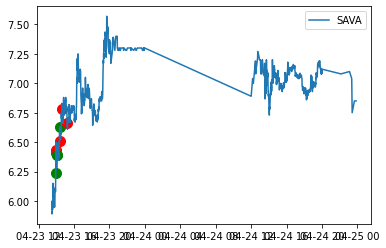

now=2020-04-23 10:07:19.818316
now=2020-04-23 10:14:20.137264
now=2020-04-23 10:15:09.502362
now=2020-04-23 10:26:46.520084
PVAC analysis for run 424 with profit 25.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1581.12,-1581.12,buy,2020-04-23 14:07:19.818316,4.32,"[4.0027, 4.12]","[4.38, 4.39, 4.43, 4.43, 4.45, 4.5]",366,"{'avg': 4.1362, 'rsi': 75.5737132800693, 'macd': [0.05635534749005444, 0.05772357716021226, 0.06053089582303972, 0.06401092160362509, 0.06714870907726223], 'vwap': 4.342, 'sell_macd': [0.03331750736788042, 0.03414081365979893, 0.035897405398179316, 0.03808309499434426, 0.040034501238181974], 'slow macd': [0.043586431711641005, 0.044852799556311496, 0.04642597077276989, 0.04819412874397333, 0.04997251937842506], 'macd_signal': [0.04900184587242469, 0.0507461921299822, 0.052703132868593704, 0.054964690615599984, 0.057401494307932434], 'resistances': [4.38, 4.39, 4.43, 4.43], 'sell_macd_signal': [0.02873291542415782, 0.029814495071286043, 0.031031077136664698, 0.03244148070820061, 0.033960084814196885]}",5.13,4.09
1,18.30,1599.42,sell,2020-04-23 14:09:05.643080,4.37,None,None,366,"{'avg': 4.151, 'rsi': 79.18439046170056, 'vwap': 4.3955, 'reasons': 'rsi max', 'movement': 0.011726833754886217, 'sell_macd': [0.035897405398179316, 0.03808309499434426, 0.040086449290130055, 0.042680148101259974, 0.04519108031641039], 'sell_macd_signal': [0.031031077136664698, 0.03244148070820061, 0.0339704744245865, 0.035712409159921195, 0.03760814339121903]}",5.13,4.09
2,-1127.92,-1146.22,buy,2020-04-23 14:14:20.137264,4.46,"[4.0027, 4.12]",[4.5],257,"{'avg': 4.2342, 'rsi': 76.45995077166234, 'macd': [0.0785929304143238, 0.08535182342902736, 0.08768028008238105, 0.09101818452495358, 0.09167872863779536], 'vwap': 4.46, 'sell_macd': [0.04726900239433274, 0.051529551163033815, 0.05288154304561843, 0.05488463356392259, 0.05513529327216116], 'slow macd': [0.05480093501571748, 0.057655427330239206, 0.059789599703847784, 0.0621612799249025, 0.06405995688169863], 'macd_signal': [0.06388469883364101, 0.06817812375271828, 0.07207855501865083, 0.07586648091991138, 0.07902893046348818], 'resistances': [4.5], 'sell_macd_signal': [0.038023727806803506, 0.04072489247804957, 0.04315622259156334, 0.04550190478603519, 0.04742858248326039]}",5.57,4.09
3,20.87,1148.79,sell,2020-04-23 14:14:42.674045,4.47,None,None,257,"{'avg': 4.2432, 'rsi': 78.9936955591282, 'vwap': 4.4998, 'reasons': 'rsi max', 'movement': 0.00896860986547086, 'sell_macd': [0.051529551163033815, 0.05288154304561843, 0.05488463356392259, 0.05513529327216116, 0.05669249183348768], 'sell_macd_signal': [0.04072489247804957, 0.04315622259156334, 0.04550190478603519, 0.04742858248326039, 0.049281364353305844]}",5.57,4.09
4,-1067.77,-1088.64,buy,2020-04-23 14:15:09.502362,4.48,"[4.0027, 4.12]",[4.5],243,"{'avg': 4.2433, 'rsi': 77.79888139372619, 'macd': [0.08535182342902736, 0.08768028008238105, 0.09101818452495358, 0.09167872863779536, 0.09274691871323792], 'vwap': 4.48, 'sell_macd': [0.051529551163033815, 0.05288154304561843, 0.05488463356392259, 0.05513529327216116, 0.05565353079452695], 'slow macd': [0.057655427330239206, 0.059789599703847784, 0.0621612799249025, 0.06405995688169863, 0.06602421751746856], 'macd_signal': [0.06817812375271828, 0.07207855501865083, 0.07586648091991138, 0.07902893046348818, 0.08177252811343813], 'resistances': [4.5], 'sell_macd_signal': [0.04072489247804957, 0.04315622259156334, 0.04550190478603519, 0.04742858248326039, 0.0490735721455137]}",5.65,4.09
5,18.44,1086.21,sell,2020-04-23 14:16:12.631758,4.47,None,None,243,"{'avg': 4.2546, 'rsi': 78.4458198664592, 'vwap': 4.4877, 'reasons': 'rsi max', 'movement': 0.0020312499999998257, 'sell_macd': [0.05488463356392259, 0.05513529327216116, 0.05565353079452695, 0.05533457911332462, 0.054840141710916335], 'sell_macd_signal': [0.04550190478603519, 0.04742858248326039, 0.0490735721455137, 0.050325773539075885, 0.05122864717344398]}",5.65,4.09
6,-808.54,-826.98,buy,2020-04-23 14:26:46.520084,4.62,"[4.0027, 4.12, 4.44]","[4.7, 4.7]",179,"{'avg': 4.3206, 'rsi': 76.50694876491147, 'macd': [0.081932725487734, 0.08272060839305873, 0.082

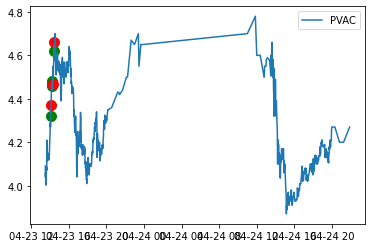

now=2020-04-23 09:48:13.560117
now=2020-04-23 09:52:47.563070
now=2020-04-23 09:52:47.782813
now=2020-04-23 09:52:47.922550
TNP analysis for run 424 with profit 51.06


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1872.56,-1872.56,buy,2020-04-23 13:48:13.560117,3.56,"[3.4, 3.415, 3.45, 3.45, 3.45, 3.46, 3.47]","[3.56, 3.56]",526,"{'avg': 3.4837, 'rsi': 73.05867938402315, 'macd': [0.032153109846782435, 0.03308681837550553, 0.032858962454983764, 0.036079201121754334, 0.0389887419447601], 'vwap': 3.57, 'sell_macd': [0.019968697604097585, 0.02047871448291927, 0.020230952122482382, 0.02223229376211, 0.02402253018568823], 'slow macd': [0.01774127899387823, 0.018628077604449178, 0.0192974143867386, 0.020638859520085706, 0.02199995900579177], 'macd_signal': [0.02342831398408852, 0.025360014862371924, 0.026859804380894293, 0.0287036837290663, 0.03076069537220506], 'resistances': [3.64, 3.76, 3.95, 3.98], 'sell_macd_signal': [0.014528184720280965, 0.015718290672808624, 0.016620822962743375, 0.0177431171226167, 0.018998999735231007]}",4.11,3.39
1,26.30,1898.86,sell,2020-04-23 13:51:19.667173,3.61,None,None,526,"{'avg': 3.4935, 'rsi': 79.34286737577803, 'vwap': 3.6156, 'reasons': 'rsi max', 'movement': 0.01677871148459392, 'sell_macd': [0.02223229376211, 0.023503049666207865, 0.025226975699709886, 0.027801113184260817, 0.03047964741658271], 'sell_macd_signal': [0.0177431171226167, 0.018895103631334932, 0.020161478045009923, 0.021689405072860102, 0.023447453541604622]}",4.11,3.39
2,-182.50,-208.80,buy,2020-04-23 13:52:47.563070,3.60,"[3.4, 3.415, 3.45, 3.45, 3.45, 3.46, 3.47]","[3.64, 3.76, 3.95, 3.98]",58,"{'avg': 3.4971, 'rsi': 73.14874269671536, 'macd': [0.038191021147039095, 0.041005797279133116, 0.04513696607460149, 0.046614810959090036, 0.04768816736763126], 'vwap': 3.6033, 'sell_macd': [0.023503049666207865, 0.025226975699709886, 0.027801113184260817, 0.028635491572427174, 0.029204676140187402], 'slow macd': [0.021840022980201823, 0.02323007377180808, 0.024951619783962542, 0.02624609035366765, 0.02748463190483763], 'macd_signal': [0.03060115121266086, 0.032682080425955315, 0.03517305755568455, 0.037461408236365644, 0.039506760062618766], 'resistances': [3.64, 3.76, 3.95, 3.98], 'sell_macd_signal': [0.018895103631334932, 0.020161478045009923, 0.021689405072860102, 0.023078622372773517, 0.024303833126256294]}",4.23,3.39
3,-765.70,-583.20,buy,2020-04-23 13:52:47.782813,3.60,"[3.4, 3.415, 3.45, 3.45, 3.45, 3.46, 3.47]","[3.64, 3.76, 3.95, 3.98]",162,"{'avg': 3.4971, 'rsi': 73.14874269671536, 'macd': [0.038191021147039095, 0.041005797279133116, 0.04513696607460149, 0.046614810959090036, 0.04768816736763126], 'vwap': 3.6033, 'sell_macd': [0.023503049666207865, 0.025226975699709886, 0.027801113184260817, 0.028635491572427174, 0.029204676140187402], 'slow macd': [0.021840022980201823, 0.02323007377180808, 0.024951619783962542, 0.02624609035366765, 0.02748463190483763], 'macd_signal': [0.03060115121266086, 0.032682080425955315, 0.03517305755568455, 0.037461408236365644, 0.039506760062618766], 'resistances': [3.64, 3.76, 3.95, 3.98], 'sell_macd_signal': [0.018895103631334932, 0.020161478045009923, 0.021689405072860102, 0.023078622372773517, 0.024303833126256294]}",4.23,3.39
4,-1597.30,-831.60,buy,2020-04-23 13:52:47.922550,3.60,"[3.4, 3.415, 3.45, 3.45, 3.45, 3.46, 3.47]","[3.64, 3.76, 3.95, 3.98]",231,"{'avg': 3.4971, 'rsi': 73.14874269671536, 'macd': [0.038191021147039095, 0.041005797279133116, 0.04513696607460149, 0.046614810959090036, 0.04768816736763126], 'vwap': 3.6033, 'sell_macd': [0.023503049666207865, 0.025226975699709886, 0.027801113184260817, 0.028635491572427174, 0.029204676140187402], 'slow macd': [0.021840022980201823, 0.02323007377180808, 0.024951619783962542, 0.02624609035366765, 0.02748463190483763], 'macd_signal': [0.03060115121266086, 0.032682080425955315, 0.03517305755568455, 0.037461408236365644, 0.039506760062618766], 'resistances': [3.64, 3.76, 3.95, 3.98], 'sell_macd_signal': [0.018895103631334932, 0.020161478045009923, 0.021689405072860102, 0.023078622372773517, 0.024303833126256294]}",4.23,3.39
5,-764.80,832.50,sell,2020-04-23 14:44:

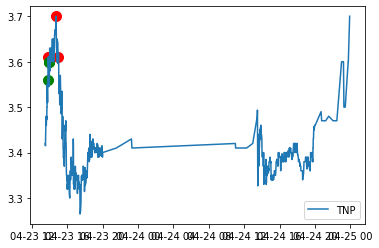

now=2020-04-23 10:04:26.967080
now=2020-04-23 10:58:35.259757
THMO analysis for run 424 with profit 124.54


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2201.29,-2201.29,buy,2020-04-23 14:04:26.967080,7.67,"[7.203, 7.3845, 7.4202]",[7.75],287,"{'avg': 7.4726, 'rsi': 66.70835586228675, 'macd': [0.033141203455547164, 0.03218347545907907, 0.031058378305616863, 0.036388192463951974, 0.051133907916049104], 'vwap': 7.6455, 'sell_macd': [0.017306619964693404, 0.01675390336306215, 0.01610043713629672, 0.019657470763021045, 0.02932714020250682], 'slow macd': [0.04344422777141688, 0.043498443331444925, 0.04347715433916122, 0.04470430564319816, 0.047964144878711146], 'macd_signal': [0.04911953306460506, 0.04573232154349986, 0.042797532895923265, 0.04151566480952901, 0.04343931343083303], 'resistances': [7.75], 'sell_macd_signal': [0.027905086363793373, 0.025674849763647128, 0.023759967238177047, 0.022939467943145848, 0.02421700239501804]}",8.66,7.34
1,-14.35,2186.94,sell,2020-04-23 14:39:43.946170,7.62,None,None,287,"{'avg': 7.5637, 'rsi': 49.775258996949525, 'vwap': 7.635, 'reasons': 'below cost & macd negative', 'movement': -0.027388535031847117, 'sell_macd': [0.00542450348699397, 0.0015771168305107608, -0.0016854846788332267, -0.00370198605392158, -0.003666766527316234], 'sell_macd_signal': [0.019049773661820334, 0.015555242295558418, 0.012107096900680089, 0.008945280309759754, 0.006422870942344556]}",8.66,7.34
2,-3536.05,-3521.70,buy,2020-04-23 14:58:35.259757,7.74,"[7.55, 7.58, 7.6301]",[7.78],455,"{'avg': 7.5753, 'rsi': 59.50783266348334, 'macd': [0.007006104159844817, 0.010169540433492053, 0.008399930215596818, 0.011049951495415655, 0.016988857609286256], 'vwap': 7.72, 'sell_macd': [0.0034269528105435043, 0.0055497297226096975, 0.0044408580992501, 0.006210037897941056, 0.010105372313830685], 'slow macd': [0.037086370612734676, 0.03698386962168332, 0.036001946287458786, 0.035869433941517315, 0.036489830325453276], 'macd_signal': [0.003194618334848074, 0.00458960275457687, 0.005351668246780859, 0.006491324896507818, 0.008590831439063506], 'resistances': [7.75, 7.78, 7.8], 'sell_macd_signal': [0.0004636988584338722, 0.0014809050312690373, 0.0020728956448652497, 0.002900324095480411, 0.004341333739150466]}",8.38,7.54
3,-1735.94,1800.11,sell,2020-04-23 15:07:42.469034,7.93,None,None,227,"{'avg': 7.5982, 'rsi': 69.15352530655461, 'vwap': 7.9225, 'reasons': 'scale-out', 'movement': 0.021935483870967734, 'sell_macd': [0.016704767711447133, 0.019452631626581507, 0.021081452448418858, 0.02389506019987042, 0.030971961562042516], 'sell_macd_signal': [0.010130375704814462, 0.011994826889167871, 0.013812152001018069, 0.015828733640788538, 0.018857379225039335]}",8.38,7.54
4,-795.44,940.50,sell,2020-04-23 15:45:15.000486,8.25,None,None,114,"{'avg': 7.7351, 'rsi': 68.99267212771866, 'vwap': 8.2423, 'reasons': 'scale-out', 'movement': 0.020940594059405942, 'sell_macd': [0.03171995174679054, 0.03138142265244781, 0.031749043843189995, 0.032147851993856946, 0.0361501979295209], 'sell_macd_signal': [0.033013504319393615, 0.032687087986004455, 0.032499479157441565, 0.032429153724724644, 0.03317336256568389]}",8.38,7.54
5,124.54,919.98,sell,2020-04-23 16:07:26.652573,8.07,None,None,114,"{'avg': 7.8025, 'rsi': 44.38760601970139, 'vwap': 8.095, 'reasons': 'below cost & macd negative', 'movement': -0.03799332533640548, 'sell_macd': [0.00870052055104864, 0.00980142230568326, 0.0081943142923393, 0.0013810572132086918, -0.0029069490460251757], 'sell_macd_signal': [0.021654556053568766, 0.019283929303991663, 0.01706600630166119, 0.01392901648397069, 0.010561823377971517]}",8.38,7.54


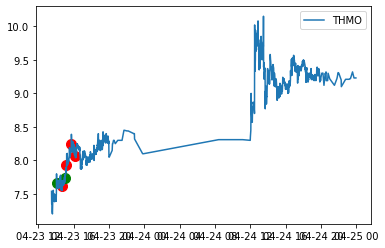

now=2020-04-23 10:06:17.897954
now=2020-04-23 10:06:18.026404
now=2020-04-23 10:15:13.004844
APY analysis for run 424 with profit 58.29


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-858.42,-858.42,buy,2020-04-23 14:06:17.897954,7.53,"[7.13, 7.15]","[7.6, 7.6152]",114,"{'avg': 7.2817, 'rsi': 71.28948513662992, 'macd': [-0.010860655269583575, -0.0009603839193461639, 0.01318894986126029, 0.027315191998644295, 0.04525096356498537], 'vwap': 7.54, 'sell_macd': [-0.010256485639174251, -0.0035388993513230105, 0.005897387358058559, 0.015251670672407514, 0.02701797363589442], 'slow macd': [0.03374315720443821, 0.03460883203700682, 0.03662941678774345, 0.039069579860232295, 0.04269154583798329], 'macd_signal': [0.0032850542242749523, 0.002435966595550729, 0.004586563248692641, 0.009132288998682972, 0.016356023911943452], 'resistances': [7.6], 'sell_macd_signal': [-0.0018594416959478166, -0.002195333227022855, -0.0005767891100065721, 0.0025889028464762447, 0.00747471700435988]}",8.74,7.14
1,-1782.15,-923.73,buy,2020-04-23 14:06:18.026404,7.51,"[7.13, 7.15]","[7.6, 7.6152]",123,"{'avg': 7.2817, 'rsi': 71.28948513662992, 'macd': [-0.010860655269583575, -0.0009603839193461639, 0.01318894986126029, 0.027315191998644295, 0.04525096356498537], 'vwap': 7.54, 'sell_macd': [-0.010256485639174251, -0.0035388993513230105, 0.005897387358058559, 0.015251670672407514, 0.02701797363589442], 'slow macd': [0.03374315720443821, 0.03460883203700682, 0.03662941678774345, 0.039069579860232295, 0.04269154583798329], 'macd_signal': [0.0032850542242749523, 0.002435966595550729, 0.004586563248692641, 0.009132288998682972, 0.016356023911943452], 'resistances': [7.6], 'sell_macd_signal': [-0.0018594416959478166, -0.002195333227022855, -0.0005767891100065721, 0.0025889028464762447, 0.00747471700435988]}",8.74,7.14
2,38.01,1820.16,sell,2020-04-23 14:12:26.796900,7.68,None,None,237,"{'avg': 7.3512, 'rsi': 78.41994811691097, 'vwap': 7.69, 'reasons': 'rsi max', 'movement': 0.01989389920424408, 'sell_macd': [0.03573165192950345, 0.045486904690196894, 0.05353662236489054, 0.061711251431340486, 0.06779912795803789], 'sell_macd_signal': [0.015910409046962642, 0.02182570817560949, 0.0281678910134657, 0.03487656309704066, 0.041461076069240106]}",8.74,7.14
3,-1263.29,-1301.30,buy,2020-04-23 14:15:13.004844,7.70,"[7.13, 7.15]","[8.09, 8.31]",169,"{'avg': 7.3697, 'rsi': 75.5049733654995, 'macd': [0.08629876478151832, 0.09916271569962198, 0.10492036709472163, 0.11102769662541512, 0.11654167051270647], 'vwap': 7.7, 'sell_macd': [0.05353662236489054, 0.061711251431340486, 0.06520172536063473, 0.06889298133981647, 0.07217327195554546], 'slow macd': [0.054151877527236714, 0.0584301652664756, 0.06163313185061181, 0.06504116607000121, 0.06847248237329406], 'macd_signal': [0.04754907249316536, 0.05787180113445668, 0.06728151432650967, 0.07603075078629076, 0.0841329347315739], 'resistances': [8.31], 'sell_macd_signal': [0.0281678910134657, 0.03487656309704066, 0.04094159554975947, 0.04653187270777087, 0.05166015255732579]}",9.38,7.14
4,-1232.01,31.28,sell,2020-04-23 14:24:17.528641,7.82,None,None,4,"{'avg': 7.4234, 'rsi': 78.30732531558667, 'vwap': 7.7958, 'reasons': 'rsi max', 'movement': 0.012987012987012941, 'sell_macd': [0.06669374414608242, 0.06553878056666118, 0.06534609751040232, 0.0653862652911048, 0.06560735362293624], 'sell_macd_signal': [0.06534694123097276, 0.06538530909811044, 0.06537746678056881, 0.06537922648267601, 0.06542485191072805]}",9.38,7.14
5,58.29,1290.30,sell,2020-04-23 14:24:17.701816,7.82,None,None,165,"{'avg': 7.4234, 'rsi': 78.30732531558667, 'vwap': 7.7958, 'reasons': 'rsi max', 'movement': 0.012987012987012941, 'sell_macd': [0.06669374414608242, 0.06553878056666118, 0.06534609751040232, 0.0653862652911048, 0.06560735362293624], 'sell_macd_signal': [0.06534694123097276, 0.06538530909811044, 0.06537746678056881, 0.06537922648267601, 0.06542485191072805]}",9.38,7.14


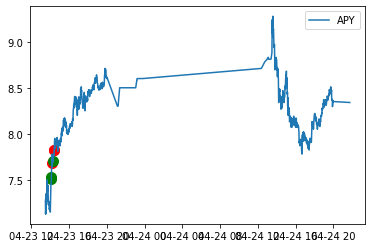

now=2020-04-23 10:35:44.203267
NS analysis for run 424 with profit -52.78


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4319.84,-4319.84,buy,2020-04-23 14:35:44.203267,10.64,[10.43],"[10.78, 10.82]",406,"{'avg': 10.4539, 'rsi': 65.84339396626024, 'macd': [0.03248335281524106, 0.03733119288887288, 0.03929994288515104, 0.04100081604023842, 0.04585476718977688], 'vwap': 10.6333, 'sell_macd': [0.019296646575602594, 0.022423875015373795, 0.02365517152668417, 0.024702218528657838, 0.027794693873978815], 'slow macd': [0.023242137868043855, 0.024839566737643537, 0.025988037574109057, 0.027124654625053424, 0.028926676702511145], 'macd_signal': [0.023158387024112846, 0.025992948197064852, 0.02865434713468209, 0.031123640915793355, 0.03406986617059006], 'resistances': [10.78, 10.82, 10.82], 'sell_macd_signal': [0.013173163200848671, 0.015023305563753695, 0.01674967875633979, 0.0183401867108034, 0.020231088143438485]}",11.35,10.4
1,-515.22,3804.62,sell,2020-04-23 14:59:22.479657,10.51,None,None,362,"{'avg': 10.5007, 'rsi': 43.3209617512911, 'vwap': 10.536, 'reasons': 'below cost & macd negative', 'movement': -0.009774436090225656, 'sell_macd': [0.0065974976766174365, 0.005741249812004412, 0.004999481997863597, 0.0012396696492107395, -0.001394465552975177], 'sell_macd_signal': [0.012585716066566466, 0.011216822815654056, 0.009973354652095964, 0.008226617651518919, 0.006302401010620099]}",11.35,10.4
2,-73.80,441.42,sell,2020-04-23 14:59:22.610467,10.51,None,None,42,"{'avg': 10.5007, 'rsi': 43.3209617512911, 'vwap': 10.536, 'reasons': 'below cost & macd negative', 'movement': -0.009774436090225656, 'sell_macd': [0.0065974976766174365, 0.005741249812004412, 0.004999481997863597, 0.0012396696492107395, -0.001394465552975177], 'sell_macd_signal': [0.012585716066566466, 0.011216822815654056, 0.009973354652095964, 0.008226617651518919, 0.006302401010620099]}",11.35,10.4
3,-52.78,21.02,sell,2020-04-23 14:59:22.802785,10.51,None,None,2,"{'avg': 10.5007, 'rsi': 43.3209617512911, 'vwap': 10.536, 'reasons': 'below cost & macd negative', 'movement': -0.009774436090225656, 'sell_macd': [0.0065974976766174365, 0.005741249812004412, 0.004999481997863597, 0.0012396696492107395, -0.001394465552975177], 'sell_macd_signal': [0.012585716066566466, 0.011216822815654056, 0.009973354652095964, 0.008226617651518919, 0.006302401010620099]}",11.35,10.4


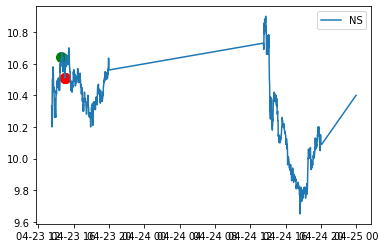

now=2020-04-23 10:29:03.318434
now=2020-04-23 10:29:03.909955
MRC analysis for run 424 with profit 81.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1975.05,-1975.05,buy,2020-04-23 14:29:03.318434,3.85,"[3.5, 3.72, 3.76]","[3.85, 3.885]",513,"{'avg': 3.7072, 'rsi': 72.64470648299746, 'macd': [0.021725699912480412, 0.022639976335457668, 0.02429486554051996, 0.026112287390178235, 0.027637477871930827], 'vwap': 3.855, 'sell_macd': [0.012279132771154444, 0.012892423824658827, 0.013982099660835523, 0.015169092524598415, 0.016156761086951743], 'slow macd': [0.024723155563841193, 0.02510961605488715, 0.025664916784866154, 0.026294699796678422, 0.02691203362754324], 'macd_signal': [0.019526820930141013, 0.020149452011204345, 0.020978534717067468, 0.02200528525168962, 0.023131723775737863], 'resistances': [3.885], 'sell_macd_signal': [0.010710360907366552, 0.011146773490825008, 0.01171383872482711, 0.012404889484781372, 0.013155263805215447]}",4.17,3.75
1,-3495.80,-1520.75,buy,2020-04-23 14:29:03.909955,3.85,"[3.5, 3.72, 3.76]","[3.85, 3.885]",395,"{'avg': 3.7072, 'rsi': 72.64470648299746, 'macd': [0.021725699912480412, 0.022639976335457668, 0.02429486554051996, 0.026112287390178235, 0.027637477871930827], 'vwap': 3.855, 'sell_macd': [0.012279132771154444, 0.012892423824658827, 0.013982099660835523, 0.015169092524598415, 0.016156761086951743], 'slow macd': [0.024723155563841193, 0.02510961605488715, 0.025664916784866154, 0.026294699796678422, 0.02691203362754324], 'macd_signal': [0.019526820930141013, 0.020149452011204345, 0.020978534717067468, 0.02200528525168962, 0.023131723775737863], 'resistances': [3.885], 'sell_macd_signal': [0.010710360907366552, 0.011146773490825008, 0.01171383872482711, 0.012404889484781372, 0.013155263805215447]}",4.17,3.75
2,-1711.58,1784.22,sell,2020-04-23 15:15:32.522898,3.93,None,None,454,"{'avg': 3.7615, 'rsi': 75.45093976020024, 'vwap': 3.9311, 'reasons': 'scale-out', 'movement': 0.020752269779507154, 'sell_macd': [0.002570750098664032, 0.003331545146920245, 0.004920066676120882, 0.00609397869009376, 0.008228274042668904], 'sell_macd_signal': [0.0024515487511634947, 0.0026275480303148448, 0.003086051759476052, 0.0036876371455995937, 0.004595764525013456]}",4.17,3.75
3,81.72,1793.30,sell,2020-04-23 15:16:36.754772,3.95,None,None,454,"{'avg': 3.7626, 'rsi': 78.2551503299511, 'vwap': 3.95, 'reasons': 'rsi max', 'movement': 0.0038119440914866896, 'sell_macd': [0.003331545146920245, 0.004920066676120882, 0.00609397869009376, 0.008488014302409308, 0.010762743165221078], 'sell_macd_signal': [0.0026275480303148448, 0.003086051759476052, 0.0036876371455995937, 0.004647712576961537, 0.005870718694613445]}",4.17,3.75


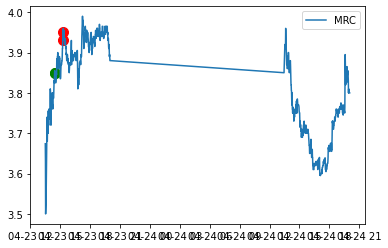

now=2020-04-23 10:13:44.001815
BLPH analysis for run 424 with profit -37.06


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1797.41,-1797.41,buy,2020-04-23 14:13:44.001815,16.49,"[15.6987, 15.7133]","[16.5, 16.5, 16.5, 16.5, 16.55, 16.58, 16.68, 16.81]",109,"{'avg': 16.0584, 'rsi': 69.88525709005351, 'macd': [0.14514020204142675, 0.14607898119260554, 0.13638282262224521, 0.13719542975233523, 0.1566104874211831], 'vwap': 16.49, 'sell_macd': [0.07931915154717473, 0.08019294197841376, 0.0741232599510866, 0.07491930954081738, 0.08781338312319775], 'slow macd': [0.2010285940993093, 0.2017384382187668, 0.20031116815319194, 0.20067526527694035, 0.20476766288615167], 'macd_signal': [0.152831359035678, 0.1514808834670635, 0.14846127129809986, 0.14620810298894693, 0.14828857987539418], 'resistances': [16.5, 16.5, 16.5, 16.5, 16.55, 16.58, 16.68, 16.81], 'sell_macd_signal': [0.08328269573669247, 0.08266474498503673, 0.0809564479782467, 0.07974902029076084, 0.08136189285724822]}",19.09,15.62
1,-1522.86,274.55,sell,2020-04-23 14:45:38.436963,16.15,None,None,17,"{'avg': 16.1332, 'rsi': 46.96956201267706, 'vwap': 16.2043, 'reasons': 'below cost & macd negative', 'movement': -0.0175864160097028, 'sell_macd': [0.023679249827338822, 0.015602996062323626, 0.010665616556305935, 0.004113559583355908, -0.0010765310395086658], 'sell_macd_signal': [0.04482488820135032, 0.03898050977354498, 0.033317531130097174, 0.027476736820748922, 0.021766083248697405]}",19.09,15.62
2,-424.66,1098.20,sell,2020-04-23 14:45:38.779719,16.15,None,None,68,"{'avg': 16.1332, 'rsi': 46.96956201267706, 'vwap': 16.2043, 'reasons': 'below cost & macd negative', 'movement': -0.0175864160097028, 'sell_macd': [0.023679249827338822, 0.015602996062323626, 0.010665616556305935, 0.004113559583355908, -0.0010765310395086658], 'sell_macd_signal': [0.04482488820135032, 0.03898050977354498, 0.033317531130097174, 0.027476736820748922, 0.021766083248697405]}",19.09,15.62
3,-37.06,387.60,sell,2020-04-23 14:45:39.995990,16.15,None,None,24,"{'avg': 16.1332, 'rsi': 46.96956201267706, 'vwap': 16.2043, 'reasons': 'below cost & macd negative', 'movement': -0.0175864160097028, 'sell_macd': [0.023679249827338822, 0.015602996062323626, 0.010665616556305935, 0.004113559583355908, -0.0010765310395086658], 'sell_macd_signal': [0.04482488820135032, 0.03898050977354498, 0.033317531130097174, 0.027476736820748922, 0.021766083248697405]}",19.09,15.62


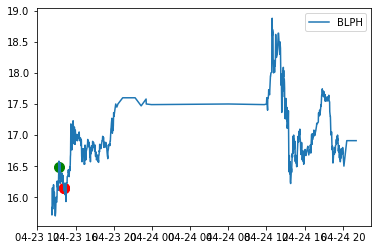

now=2020-04-23 10:36:00.850969
now=2020-04-23 10:36:01.088624
CLR analysis for run 424 with profit 62.44


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1528.88,-1528.88,buy,2020-04-23 14:36:00.850969,13.18,"[12.615, 12.7, 12.835]","[13.44, 13.44, 13.44, 13.5, 13.64]",116,"{'avg': 12.8991, 'rsi': 68.01894196491536, 'macd': [0.05440893770259336, 0.048120239876672244, 0.045436841410474216, 0.05550840282401737, 0.0649843167198263], 'vwap': 13.1877, 'sell_macd': [0.0323159864530016, 0.0281354538169456, 0.026330682232785563, 0.03284734486548224, 0.03894283074984983], 'slow macd': [0.05645916439920029, 0.055726567556169115, 0.055523204259072756, 0.05779188408168068, 0.0602313341958336], 'macd_signal': [0.05037013095442639, 0.04992015273887556, 0.04902349047319529, 0.05032047294335971, 0.053253241698653024], 'resistances': [13.44, 13.44, 13.44, 13.5, 13.64], 'sell_macd_signal': [0.030011157695549406, 0.029636016919828645, 0.028974949982420027, 0.02974942895903247, 0.03158810931719594]}",14.38,12.79
1,-3161.96,-1633.08,buy,2020-04-23 14:36:01.088624,13.17,"[12.615, 12.7, 12.835]","[13.44, 13.44, 13.44, 13.5, 13.64]",124,"{'avg': 12.8991, 'rsi': 68.01894196491536, 'macd': [0.05440893770259336, 0.048120239876672244, 0.045436841410474216, 0.05550840282401737, 0.0649843167198263], 'vwap': 13.1877, 'sell_macd': [0.0323159864530016, 0.0281354538169456, 0.026330682232785563, 0.03284734486548224, 0.03894283074984983], 'slow macd': [0.05645916439920029, 0.055726567556169115, 0.055523204259072756, 0.05779188408168068, 0.0602313341958336], 'macd_signal': [0.05037013095442639, 0.04992015273887556, 0.04902349047319529, 0.05032047294335971, 0.053253241698653024], 'resistances': [13.44, 13.44, 13.44, 13.5, 13.64], 'sell_macd_signal': [0.030011157695549406, 0.029636016919828645, 0.028974949982420027, 0.02974942895903247, 0.03158810931719594]}",14.38,12.79
2,-1545.56,1616.40,sell,2020-04-23 14:56:37.694248,13.47,None,None,120,"{'avg': 12.9812, 'rsi': 75.49385768574395, 'vwap': 13.4516, 'reasons': 'scale-out', 'movement': 0.020709946992849056, 'sell_macd': [0.03149661850057761, 0.03899337503128919, 0.04536755706780049, 0.050784224147319534, 0.05642339038918642], 'sell_macd_signal': [0.03335009226162772, 0.03447874881556001, 0.03665651046600811, 0.0394820532022704, 0.042870320639653604]}",14.38,12.79
3,62.44,1608.00,sell,2020-04-23 15:32:12.716079,13.40,None,None,120,"{'avg': 13.1228, 'rsi': 44.239969848303154, 'vwap': 13.42, 'reasons': 'below cost & macd negative', 'movement': -0.003343239227340394, 'sell_macd': [0.014167120866371619, 0.01096960563059568, 0.008335572906219113, 0.004096903602727409, -3.8382914315349126e-05], 'sell_macd_signal': [0.02891668621696498, 0.025327270099691122, 0.021928930660996722, 0.01836252524934286, 0.014682343616611217]}",14.38,12.79


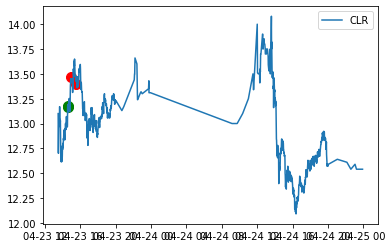

now=2020-04-23 10:08:11.244481
now=2020-04-23 10:08:11.429299
NBL analysis for run 424 with profit 108.3


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3438.76,-3438.76,buy,2020-04-23 14:08:11.244481,7.78,"[7.35, 7.4, 7.51, 7.56, 7.622]","[7.9599, 7.99, 8.0, 8.02, 8.2]",442,"{'avg': 7.6622, 'rsi': 67.82942393538647, 'macd': [0.031723490248333874, 0.036307947716366584, 0.04108143493244487, 0.04395432166945845, 0.04849627769795095], 'vwap': 7.7884, 'sell_macd': [0.01631658161859484, 0.019416260846702116, 0.022618397117348366, 0.024560082560483032, 0.027572303911490792], 'slow macd': [0.05616854759002088, 0.05692241065946657, 0.05784482140723046, 0.05852098607935119, 0.059609259156613525], 'macd_signal': [0.04010195496507422, 0.03934315351533269, 0.039690809798755125, 0.04054351217289579, 0.04213406527790682], 'resistances': [7.99, 8.0, 8.02, 8.2], 'sell_macd_signal': [0.0214895502273491, 0.021074892351219704, 0.021383593304445437, 0.022018891155652955, 0.023129573706820523]}",8.43,7.59
1,-3508.78,-70.02,buy,2020-04-23 14:08:11.429299,7.78,"[7.35, 7.4, 7.51, 7.56, 7.622]","[7.9599, 7.99, 8.0, 8.02, 8.2]",9,"{'avg': 7.6622, 'rsi': 67.82942393538647, 'macd': [0.031723490248333874, 0.036307947716366584, 0.04108143493244487, 0.04395432166945845, 0.04849627769795095], 'vwap': 7.7884, 'sell_macd': [0.01631658161859484, 0.019416260846702116, 0.022618397117348366, 0.024560082560483032, 0.027572303911490792], 'slow macd': [0.05616854759002088, 0.05692241065946657, 0.05784482140723046, 0.05852098607935119, 0.059609259156613525], 'macd_signal': [0.04010195496507422, 0.03934315351533269, 0.039690809798755125, 0.04054351217289579, 0.04213406527790682], 'resistances': [7.99, 8.0, 8.02, 8.2], 'sell_macd_signal': [0.0214895502273491, 0.021074892351219704, 0.021383593304445437, 0.022018891155652955, 0.023129573706820523]}",8.43,7.59
2,-1717.78,1791.00,sell,2020-04-23 14:29:39.639919,7.96,None,None,225,"{'avg': 7.7024, 'rsi': 74.95290052578295, 'vwap': 7.9602, 'reasons': 'scale-out', 'movement': 0.02051282051282053, 'sell_macd': [0.024515556436894848, 0.02613039516080562, 0.028036368255271782, 0.029676913935955618, 0.033167249350308126], 'sell_macd_signal': [0.024016158091741825, 0.024439005505554584, 0.025158478055498024, 0.026062165231589544, 0.02748318205533326]}",8.43,7.59
3,108.30,1826.08,sell,2020-04-23 14:41:10.302098,8.08,None,None,226,"{'avg': 7.7482, 'rsi': 78.75998013390875, 'vwap': 8.0737, 'reasons': 'rsi max', 'movement': 0.015075376884422124, 'sell_macd': [0.042662991299025954, 0.0432506712846088, 0.04340664697097729, 0.0429644637789135, 0.044139847476280636], 'sell_macd_signal': [0.03718976042545823, 0.038401942597288345, 0.03940288347202613, 0.0401151995334036, 0.04092012912197901]}",8.43,7.59


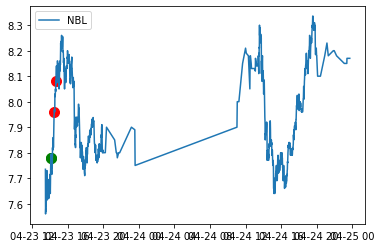

now=2020-04-23 10:35:08.370648
PE analysis for run 424 with profit 42.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2803.02,-2803.02,buy,2020-04-23 14:35:08.370648,8.22,[7.975],[8.2277],341,"{'avg': 8.0321, 'rsi': 76.58825419809679, 'macd': [0.04485103426555703, 0.045554658018003735, 0.04758109078111161, 0.05341284191139728, 0.058170905139839135], 'vwap': 8.2445, 'sell_macd': [0.02726001730826333, 0.02762365591114957, 0.02884696318728075, 0.03254243686754599, 0.035518878217525085], 'slow macd': [0.04496595519957047, 0.04554206686417128, 0.04639910991606744, 0.048073024199453585, 0.04969612882531216], 'macd_signal': [0.03468242079735865, 0.036856868241487664, 0.03900171274941246, 0.04188393858180942, 0.04514133189341536], 'resistances': [8.42, 8.49], 'sell_macd_signal': [0.0207953024490141, 0.022160973141441193, 0.023498171150609103, 0.02530702429399648, 0.027349395078702203]}",9.08,7.96
1,-1373.32,1429.70,sell,2020-04-23 15:19:21.863844,8.41,None,None,170,"{'avg': 8.1042, 'rsi': 76.28968322530558, 'vwap': 8.402, 'reasons': 'scale-out', 'movement': 0.020012128562765425, 'sell_macd': [0.02337042045254556, 0.023812672609542673, 0.024886990230456263, 0.02618013395804475, 0.027367257200866746], 'sell_macd_signal': [0.018946937772301314, 0.019920084739749586, 0.020913465837890922, 0.021966799461921687, 0.023046891009710697]}",9.08,7.96
2,42.56,1415.88,sell,2020-04-23 15:32:06.913829,8.28,None,None,171,"{'avg': 8.1218, 'rsi': 37.475392896156315, 'vwap': 8.27, 'reasons': 'below cost & macd negative', 'movement': -0.01664684898929852, 'sell_macd': [0.009275699918353197, 0.007122691331234776, 0.005612260077231923, 0.0015052713068754997, -0.001974268920765354], 'sell_macd_signal': [0.01714256780377544, 0.015138592509267306, 0.01323332602286023, 0.010887715079663284, 0.008315318279577556]}",9.08,7.96


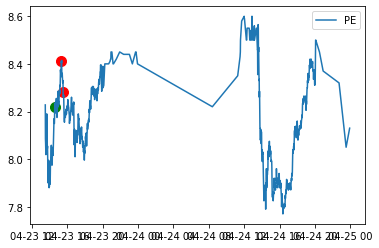

now=2020-04-23 10:36:15.975751
now=2020-04-23 10:36:16.078674
OBSV analysis for run 424 with profit 12.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1654.83,-1654.83,buy,2020-04-23 14:36:15.975751,2.43,[2.35],[2.73],681,"{'avg': 2.3748, 'rsi': 76.2359649476402, 'macd': [0.010219579591242312, 0.011985491349540744, 0.01278573000519323, 0.013586079607140977, 0.01525488821713239], 'vwap': 2.43, 'sell_macd': [0.005994101618469916, 0.007137920051634161, 0.007645597791091419, 0.008149689564810103, 0.009215869004528088], 'slow macd': [0.013479291497663581, 0.013856720363187858, 0.014092240930208444, 0.014350363225687612, 0.014804796631923356], 'macd_signal': [0.008543092383904344, 0.009231572177031624, 0.009942403742663945, 0.01067113891555935, 0.011587888775873958], 'resistances': [2.73], 'sell_macd_signal': [0.004876945188577177, 0.005329140161188574, 0.005792431687169143, 0.006263883262697336, 0.006854280411063486]}",2.65,2.36
1,-3090.96,-1436.13,buy,2020-04-23 14:36:16.078674,2.43,[2.35],[2.73],591,"{'avg': 2.3748, 'rsi': 76.2359649476402, 'macd': [0.010219579591242312, 0.011985491349540744, 0.01278573000519323, 0.013586079607140977, 0.01525488821713239], 'vwap': 2.43, 'sell_macd': [0.005994101618469916, 0.007137920051634161, 0.007645597791091419, 0.008149689564810103, 0.009215869004528088], 'slow macd': [0.013479291497663581, 0.013856720363187858, 0.014092240930208444, 0.014350363225687612, 0.014804796631923356], 'macd_signal': [0.008543092383904344, 0.009231572177031624, 0.009942403742663945, 0.01067113891555935, 0.011587888775873958], 'resistances': [2.73], 'sell_macd_signal': [0.004876945188577177, 0.005329140161188574, 0.005792431687169143, 0.006263883262697336, 0.006854280411063486]}",2.65,2.36
2,12.72,3103.68,sell,2020-04-23 14:36:43.395341,2.44,None,None,1272,"{'avg': 2.3794, 'rsi': 78.5812760530627, 'vwap': 2.439, 'reasons': 'rsi max', 'movement': 0.0041152263374484715, 'sell_macd': [0.005994101618469916, 0.007137920051634161, 0.007645597791091419, 0.008149689564810103, 0.00973534952400934], 'sell_macd_signal': [0.004876945188577177, 0.005329140161188574, 0.005792431687169143, 0.006263883262697336, 0.006958176514959736]}",2.65,2.36


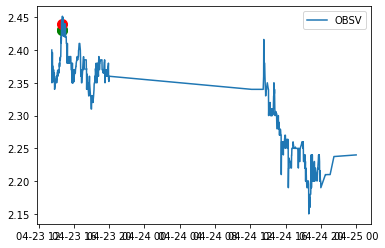

now=2020-04-23 10:10:24.031572
TRGP analysis for run 424 with profit 87.42


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3336.84,-3336.84,buy,2020-04-23 14:10:24.031572,8.97,"[8.3, 8.33, 8.45, 8.7466]",[8.97],372,"{'avg': 8.8188, 'rsi': 65.23902325668783, 'macd': [0.05038851712763304, 0.054590932647966994, 0.05367156095993231, 0.05632821777460606, 0.0589643082388136], 'vwap': 8.975, 'sell_macd': [0.02754745101985634, 0.030394915224457364, 0.02988131700434593, 0.031690444144464536, 0.03346781017384792], 'slow macd': [0.07868743434918457, 0.07944166614880466, 0.07928881557156942, 0.07982105689883667, 0.08042297735723025], 'macd_signal': [0.046581530307870156, 0.04818341077588952, 0.04928104081269808, 0.050690476205079674, 0.05234524261182646], 'resistances': [9.05], 'sell_macd_signal': [0.024468170841931387, 0.02565351971843658, 0.026499079175618452, 0.027537352169387668, 0.02872344377027972]}",9.74,8.72
1,-1634.94,1701.90,sell,2020-04-23 14:36:07.830889,9.15,None,None,186,"{'avg': 8.8906, 'rsi': 71.91804295495902, 'vwap': 9.1549, 'reasons': 'scale-out', 'movement': 0.020055710306406654, 'sell_macd': [0.0324632271695684, 0.03192080691949606, 0.033680988452951865, 0.03461514304456692, 0.035672729180310725], 'sell_macd_signal': [0.02963832761806961, 0.030094823478354897, 0.030812056473274292, 0.03157267378753282, 0.0323926848660884]}",9.74,8.72
2,87.42,1722.36,sell,2020-04-23 14:43:28.553995,9.26,None,None,186,"{'avg': 8.9206, 'rsi': 78.22587972794017, 'vwap': 9.2549, 'reasons': 'rsi max', 'movement': 0.010922992900054771, 'sell_macd': [0.036389646196603564, 0.036983156637232284, 0.03715753936191568, 0.03895631110372122, 0.0408909863427418], 'sell_macd_signal': [0.034415017021014585, 0.034928644944258125, 0.03537442382778964, 0.036090801282975954, 0.037050838294929125]}",9.74,8.72


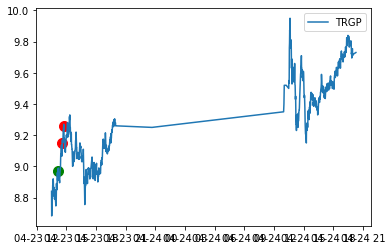

now=2020-04-23 10:44:37.559105
SLB analysis for run 424 with profit 4.56


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3791.64,-3791.64,buy,2020-04-23 14:44:37.559105,16.63,"[16.27, 16.365]","[16.88, 16.88, 16.88, 16.88]",228,"{'avg': 16.234, 'rsi': 76.41204133236916, 'macd': [0.038539752412773964, 0.046793546941295006, 0.05432237687741548, 0.060000834783181745, 0.06655802163490065], 'vwap': 16.6209, 'sell_macd': [0.02182312826118249, 0.027245745587730852, 0.03215628187351527, 0.03582479999395005, 0.040036310217743676], 'slow macd': [0.08879367628102841, 0.08950075739852181, 0.09032802274108676, 0.09102463428138563, 0.09207973408830128], 'macd_signal': [0.030752410482788414, 0.03396063777448973, 0.038032985595074884, 0.04242655543269626, 0.047252848673137136], 'resistances': [16.79, 16.88, 16.88, 16.88, 16.88, 16.98], 'sell_macd_signal': [0.016203513499624136, 0.01841195991724548, 0.021160824308499436, 0.02409361944558956, 0.027282157600020382]}",17.89,16.21
1,-2875.89,915.75,sell,2020-04-23 14:45:27.962840,16.65,None,None,55,"{'avg': 16.2364, 'rsi': 78.16008141107143, 'vwap': 16.6553, 'reasons': 'rsi max', 'movement': 0.001683704149128217, 'sell_macd': [0.027245745587730852, 0.03215628187351527, 0.03582479999395005, 0.03977656995800416, 0.04405357811235788], 'sell_macd_signal': [0.01841195991724548, 0.021160824308499436, 0.02409361944558956, 0.027230209548072478, 0.03059488326092956]}",17.89,16.21
2,4.56,2880.45,sell,2020-04-23 14:45:28.037457,16.65,None,None,173,"{'avg': 16.2364, 'rsi': 78.16008141107143, 'vwap': 16.6553, 'reasons': 'rsi max', 'movement': 0.001683704149128217, 'sell_macd': [0.027245745587730852, 0.03215628187351527, 0.03582479999395005, 0.03977656995800416, 0.04405357811235788], 'sell_macd_signal': [0.01841195991724548, 0.021160824308499436, 0.02409361944558956, 0.027230209548072478, 0.03059488326092956]}",17.89,16.21


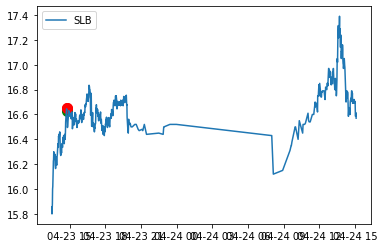

now=2020-04-23 09:48:27.827406
NEPT analysis for run 424 with profit 18.92


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1016.95,-1016.95,buy,2020-04-23 13:48:27.827406,2.15,[1.98],[2.22],473,"{'avg': 2.0687, 'rsi': 73.44366585246246, 'macd': [0.044749001479712724, 0.040627392556088715, 0.03693522154691209, 0.040003347148874546, 0.04514215384957021], 'vwap': 2.1363, 'sell_macd': [0.027210669470061788, 0.024391575538216248, 0.021878105259658387, 0.023791269909358093, 0.02705099210510653], 'slow macd': [0.023264038693070255, 0.023503808278634963, 0.02368681291009045, 0.025096787482397076, 0.026993614487973883], 'macd_signal': [0.04604897896491609, 0.044964661683150615, 0.04335877365590291, 0.04268768835449724, 0.04317858145351183], 'resistances': [2.22], 'sell_macd_signal': [0.028733917477262637, 0.02786544908945336, 0.026667980323494364, 0.02609263824066711, 0.026284309013554993]}",2.75,1.95
1,-309.58,707.37,sell,2020-04-23 13:57:42.614480,2.19,None,None,323,"{'avg': 2.0855, 'rsi': 73.31532418255352, 'vwap': 2.1984, 'reasons': 'bail', 'movement': 0.023255813953488497, 'sell_macd': [0.029753816503083286, 0.02934249431708391, 0.029020132947252364, 0.028584265218198457, 0.02995652068623178], 'sell_macd_signal': [0.02884484189588065, 0.028944372380121302, 0.028959524493547516, 0.028884472638477703, 0.029098882248028517]}",2.75,1.95
2,18.92,328.50,sell,2020-04-23 13:57:42.722582,2.19,None,None,150,"{'avg': 2.0855, 'rsi': 73.31532418255352, 'vwap': 2.1984, 'reasons': 'bail', 'movement': 0.023255813953488497, 'sell_macd': [0.029753816503083286, 0.02934249431708391, 0.029020132947252364, 0.028584265218198457, 0.02995652068623178], 'sell_macd_signal': [0.02884484189588065, 0.028944372380121302, 0.028959524493547516, 0.028884472638477703, 0.029098882248028517]}",2.75,1.95


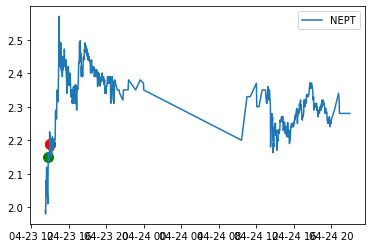

now=2020-04-23 09:55:18.251671
now=2020-04-23 09:55:18.436641
NMIH analysis for run 424 with profit 34.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-227.43,-227.43,buy,2020-04-23 13:55:18.251671,10.83,"[10.05, 10.19, 10.22]","[10.85, 10.96, 11.01, 11.01]",21,"{'avg': 10.5986, 'rsi': 70.54144883361988, 'macd': [0.10296609578498561, 0.1190716111799599, 0.12076030146172201, 0.12150488442935092, 0.1238944592965332], 'vwap': 10.8251, 'sell_macd': [0.06350348844238596, 0.07366413082527679, 0.07439107124278621, 0.07451088103249681, 0.07571448760847233], 'slow macd': [0.05289887007091387, 0.05852185595027137, 0.06168235298529723, 0.06465139507472273, 0.06791935199894006], 'macd_signal': [0.08925573482853372, 0.09521891009881896, 0.10032718837139956, 0.10456272758298983, 0.1084290739256985], 'resistances': [10.9], 'sell_macd_signal': [0.05580550640809796, 0.05937723129153373, 0.062379999281784226, 0.06480617563192674, 0.06698783802723586]}",12.45,10.29
1,-1884.42,-1656.99,buy,2020-04-23 13:55:18.436641,10.83,"[10.05, 10.19, 10.22]","[10.85, 10.96, 11.01, 11.01]",153,"{'avg': 10.5986, 'rsi': 70.54144883361988, 'macd': [0.10296609578498561, 0.1190716111799599, 0.12076030146172201, 0.12150488442935092, 0.1238944592965332], 'vwap': 10.8251, 'sell_macd': [0.06350348844238596, 0.07366413082527679, 0.07439107124278621, 0.07451088103249681, 0.07571448760847233], 'slow macd': [0.05289887007091387, 0.05852185595027137, 0.06168235298529723, 0.06465139507472273, 0.06791935199894006], 'macd_signal': [0.08925573482853372, 0.09521891009881896, 0.10032718837139956, 0.10456272758298983, 0.1084290739256985], 'resistances': [10.9], 'sell_macd_signal': [0.05580550640809796, 0.05937723129153373, 0.062379999281784226, 0.06480617563192674, 0.06698783802723586]}",12.45,10.29
2,34.80,1919.22,sell,2020-04-23 14:15:50.686672,11.03,None,None,174,"{'avg': 10.6895, 'rsi': 75.70507080128615, 'vwap': 11.0485, 'reasons': 'bail', 'movement': 0.02031394275161594, 'sell_macd': [0.055387366137548355, 0.05473159486988344, 0.054029284857808335, 0.05485827335673932, 0.05531127383179246], 'sell_macd_signal': [0.05885053873751398, 0.05802674996398787, 0.057227256942751964, 0.05675346022554943, 0.05646502294679804]}",12.45,10.29


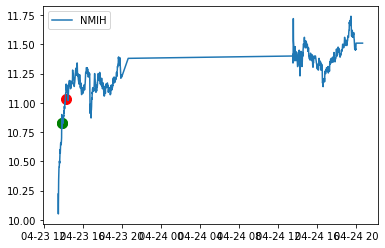

now=2020-04-23 10:04:50.541987
GTX analysis for run 424 with profit 74.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2443.97,-2443.97,buy,2020-04-23 14:04:50.541987,3.61,"[3.4299, 3.5, 3.5168]",[3.6493],677,"{'avg': 3.5327, 'rsi': 67.38535713163371, 'macd': [0.00723504337627956, 0.006390182938719402, 0.009644036636486053, 0.011285727862525796, 0.0172296656850639], 'vwap': 3.6113, 'sell_macd': [0.0036323369755972834, 0.003101854182248509, 0.005245609743505852, 0.006328463301063625, 0.010206940575769874], 'slow macd': [0.008762728555651744, 0.008679666316970813, 0.009389044615062847, 0.009866742849948817, 0.011250076183444424], 'macd_signal': [0.012619372534264806, 0.011373534615155726, 0.011027635019421791, 0.011079253588042593, 0.012309336007446854], 'resistances': [3.6493], 'sell_macd_signal': [0.0072325027934729514, 0.006406373071228063, 0.0061742204056836215, 0.006205068984759622, 0.007005443302961672]}",4.04,3.48
1,-1196.75,1247.22,sell,2020-04-23 14:11:52.445502,3.69,None,None,338,"{'avg': 3.5434, 'rsi': 71.82918505420855, 'vwap': 3.6986, 'reasons': 'scale-out', 'movement': 0.021712707182320382, 'sell_macd': [0.013616053509622361, 0.018173595360551076, 0.02044994491503349, 0.02143865956898061, 0.02497481826596548], 'sell_macd_signal': [0.00832756534429381, 0.010296771347545263, 0.01232740606104291, 0.01414965676263045, 0.016314689063297458]}",4.04,3.48
2,74.50,1271.25,sell,2020-04-23 14:21:35.536611,3.75,None,None,339,"{'avg': 3.5635, 'rsi': 79.6765020988174, 'vwap': 3.8, 'reasons': 'rsi max', 'movement': 0.005370796624070631, 'sell_macd': [0.035166447141147916, 0.03559184470893095, 0.03572083184345143, 0.03620938244381211, 0.03786527404871887], 'sell_macd_signal': [0.028146916764754063, 0.02963590235358944, 0.03085288825156184, 0.031924187090011893, 0.03311240448175329]}",4.04,3.48


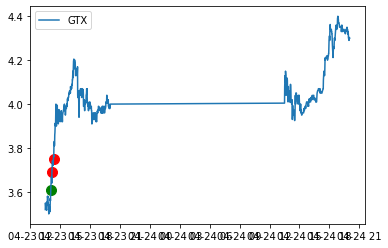

now=2020-04-23 10:30:12.324804
USAC analysis for run 424 with profit 74.8


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3209.6,-3209.6,buy,2020-04-23 14:30:12.324804,9.44,"[8.33, 8.44, 8.45, 8.7, 8.94]",[10.98],340,"{'avg': 9.0568, 'rsi': 75.44514814588145, 'macd': [0.05934606523173791, 0.06353797890426627, 0.06576311948639812, 0.06788978952098645, 0.07516407755924348], 'vwap': 9.44, 'sell_macd': [0.032892092534881456, 0.03569999847450589, 0.037206158966752056, 0.038634255987116006, 0.04340115943172229], 'slow macd': [0.0933970152863619, 0.09409191997870181, 0.09451359451575136, 0.09497749644765463, 0.0965318860356259], 'macd_signal': [0.06057507179841364, 0.061167653219584166, 0.06208674647294696, 0.06324735508255486, 0.06563069957789258], 'resistances': [10.98], 'sell_macd_signal': [0.03333344002245835, 0.03380675171286786, 0.0344866331636447, 0.03531615772833896, 0.03693315806901563]}",10.28,9.16
1,-1572.5,1637.1,sell,2020-04-23 15:15:06.203393,9.63,None,None,170,"{'avg': 9.2004, 'rsi': 74.40076516761415, 'vwap': 9.6255, 'reasons': 'scale-out', 'movement': 0.020127118644067934, 'sell_macd': [0.006650515966528658, 0.009429856443787799, 0.01251207166705548, 0.014746108572627037, 0.019417486569533793], 'sell_macd_signal': [0.010254855859918194, 0.010089855976692114, 0.010574299114764787, 0.011408661006337237, 0.013010426118976548]}",10.28,9.16
2,74.8,1647.3,sell,2020-04-23 15:15:11.537916,9.69,None,None,170,"{'avg': 9.207, 'rsi': 79.62243199268997, 'vwap': 9.6991, 'reasons': 'rsi max', 'movement': 0.007268951194184683, 'sell_macd': [0.009429856443787799, 0.01251207166705548, 0.014746108572627037, 0.019417486569533793, 0.026441709858428197], 'sell_macd_signal': [0.010089855976692114, 0.010574299114764787, 0.011408661006337237, 0.013010426118976548, 0.015696682866866877]}",10.28,9.16


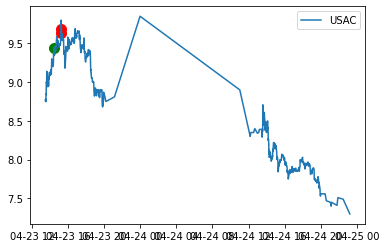

now=2020-04-23 10:05:05.330194
SOI analysis for run 424 with profit -24.72


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2480.24,-2480.24,buy,2020-04-23 14:05:05.330194,6.02,"[5.78, 5.8]","[6.06, 6.06, 6.06]",412,"{'avg': 5.8218, 'rsi': 77.47811285860098, 'macd': [0.03342980708818111, 0.03574507830197504, 0.037949406708200684, 0.044429157947173614, 0.054184756120760014], 'vwap': 6.02, 'sell_macd': [0.018480027931992993, 0.020007093057272662, 0.02145666207622643, 0.025684161804291783, 0.0320213802702618], 'slow macd': [0.036102851856224305, 0.036956302880655656, 0.037842334706202685, 0.03963657296760292, 0.04226352056760696], 'macd_signal': [0.04085586586054016, 0.039833708348827136, 0.039456848020701846, 0.0404513100059962, 0.043197999228948965], 'resistances': [6.04, 6.06, 6.06, 6.06], 'sell_macd_signal': [0.02353000445616204, 0.022825422176384162, 0.022551670156352614, 0.023178168485940447, 0.024946810842804718]}",6.71,5.79
1,-221.40,2258.84,sell,2020-04-23 14:35:12.548612,5.96,None,None,379,"{'avg': 5.8736, 'rsi': 42.75635714384665, 'vwap': 5.9673, 'reasons': 'below cost & macd negative', 'movement': -0.00988372093023254, 'sell_macd': [0.011170911179803511, 0.007993903674820224, 0.004375535441393907, 0.0023979038901345007, -4.697658993890741e-05], 'sell_macd_signal': [0.018769824385402895, 0.01661464024328636, 0.01416681928290787, 0.011813036204353197, 0.009441033645494775]}",6.71,5.79
2,-24.72,196.68,sell,2020-04-23 14:35:12.691101,5.96,None,None,33,"{'avg': 5.8736, 'rsi': 42.75635714384665, 'vwap': 5.9673, 'reasons': 'below cost & macd negative', 'movement': -0.00988372093023254, 'sell_macd': [0.011170911179803511, 0.007993903674820224, 0.004375535441393907, 0.0023979038901345007, -4.697658993890741e-05], 'sell_macd_signal': [0.018769824385402895, 0.01661464024328636, 0.01416681928290787, 0.011813036204353197, 0.009441033645494775]}",6.71,5.79


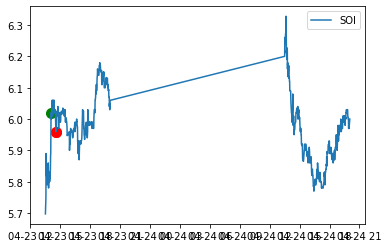

now=2020-04-23 10:02:22.886173
now=2020-04-23 10:02:23.098538
VNOM analysis for run 424 with profit 15.75


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1093.85,-1093.85,buy,2020-04-23 14:02:22.886173,8.35,[7.97],"[8.38, 8.5485]",131,"{'avg': 8.1003, 'rsi': 76.08819002434035, 'macd': [0.03304063756733644, 0.033570715652549765, 0.03280572593979603, 0.03901200777806757, 0.06177747636613695], 'vwap': 8.36, 'sell_macd': [0.016495271549847423, 0.01696959149785293, 0.016599326632691813, 0.020770557560712888, 0.035699171822017206], 'slow macd': [0.05812627685679317, 0.0581030668008955, 0.05782884904566821, 0.05892349500689953, 0.06351489299840996], 'macd_signal': [0.04927996017347852, 0.04613811126929277, 0.04347163420339342, 0.042579708918328255, 0.046419262407889995], 'resistances': [8.38, 8.5485], 'sell_macd_signal': [0.027015679467226612, 0.025006461873351878, 0.023325034825219866, 0.022814139372318472, 0.02539114586225822]}",9.62,7.94
1,-1878.75,-784.90,buy,2020-04-23 14:02:23.098538,8.35,[7.97],"[8.38, 8.5485]",94,"{'avg': 8.1003, 'rsi': 76.08819002434035, 'macd': [0.03304063756733644, 0.033570715652549765, 0.03280572593979603, 0.03901200777806757, 0.06177747636613695], 'vwap': 8.36, 'sell_macd': [0.016495271549847423, 0.01696959149785293, 0.016599326632691813, 0.020770557560712888, 0.035699171822017206], 'slow macd': [0.05812627685679317, 0.0581030668008955, 0.05782884904566821, 0.05892349500689953, 0.06351489299840996], 'macd_signal': [0.04927996017347852, 0.04613811126929277, 0.04347163420339342, 0.042579708918328255, 0.046419262407889995], 'resistances': [8.38, 8.5485], 'sell_macd_signal': [0.027015679467226612, 0.025006461873351878, 0.023325034825219866, 0.022814139372318472, 0.02539114586225822]}",9.62,7.94
2,15.75,1894.50,sell,2020-04-23 14:55:59.571996,8.42,None,None,225,"{'avg': 8.2545, 'rsi': 46.51897200982834, 'vwap': 8.425, 'reasons': 'below cost & macd negative', 'movement': -0.012895662368112478, 'sell_macd': [0.006729272972469502, 0.0041809733883546585, 0.0016215065255593686, 0.001424240054218373, -0.0005661525215572283], 'sell_macd_signal': [0.020361245050076908, 0.01712519071773246, 0.01402445387929784, 0.011504411114281948, 0.009090298387114112]}",9.62,7.94


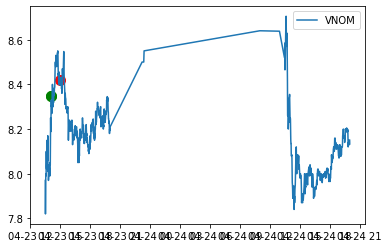

now=2020-04-23 10:20:27.752773
FI analysis for run 424 with profit 27.13


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2054.35,-2054.35,buy,2020-04-23 14:20:27.752773,2.27,"[2.1, 2.145, 2.18, 2.19]","[2.34, 2.34, 2.34]",905,"{'avg': 2.2137, 'rsi': 67.15866878654448, 'macd': [0.006232947355736762, 0.008699246731063592, 0.015318720637874428, 0.018734904232807104, 0.02079903777034353], 'vwap': 2.2724, 'sell_macd': [0.003407567327418981, 0.0050278103287770826, 0.009341924221669462, 0.01154328668078497, 0.012848980977747892], 'slow macd': [0.0087967081296636, 0.009307224978678974, 0.010721647357595732, 0.011685941361776475, 0.012474464647731054], 'macd_signal': [0.005500423306563025, 0.006140187991463138, 0.007975894520745395, 0.010127696463157736, 0.012261964724594895], 'resistances': [2.3], 'sell_macd_signal': [0.0028558774243531105, 0.003290264005237905, 0.004500596048524217, 0.0059091341749763675, 0.007297103535530673]}",2.59,2.17
1,-1005.71,1048.64,sell,2020-04-23 15:21:13.824895,2.32,None,None,452,"{'avg': 2.2518, 'rsi': 62.66009918035422, 'vwap': 2.325, 'reasons': 'scale-out', 'movement': 0.021978021978022098, 'sell_macd': [0.002845943290159525, 0.0025832863238028914, 0.002604809644514816, 0.0028474926263091227, 0.004038576863729215], 'sell_macd_signal': [0.0037782983254021755, 0.0035392959250823185, 0.003352398668968818, 0.003251417460436879, 0.0034088493410953462]}",2.59,2.17
2,27.13,1032.84,sell,2020-04-23 15:39:32.416807,2.28,None,None,453,"{'avg': 2.2562, 'rsi': 44.83370431026913, 'vwap': 2.2889, 'reasons': 'below cost & macd negative', 'movement': -0.01720430107526883, 'sell_macd': [0.0012352960629096188, 0.0005979165019249777, 0.00035323221411953654, 0.00015798170136038792, -0.0005156937852230925], 'sell_macd_signal': [0.0025856819867401282, 0.002188128889777098, 0.0018211495546455857, 0.0014885159839885462, 0.0010876740301462185]}",2.59,2.17


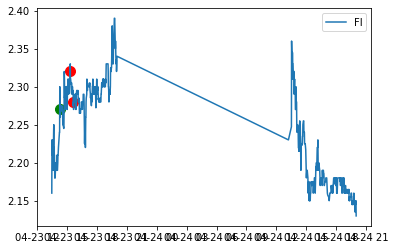

now=2020-04-23 09:50:01.912435
now=2020-04-23 09:50:02.097763
CUTR analysis for run 424 with profit 14.5


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-689.0,-689.0,buy,2020-04-23 13:50:01.912435,13.0,"[11.78, 11.81, 11.92, 12.19]","[13.22, 13.22, 13.23, 13.275, 13.28, 13.35, 13.42, 13.42, 13.44]",53,"{'avg': 12.6498, 'rsi': 77.32053254125505, 'macd': [0.24658686234693228, 0.2544868104185447, 0.24818748984310268, 0.2512089624424796, 0.25549975764207566], 'vwap': 13.0, 'sell_macd': [0.15327344901010953, 0.15759054997446853, 0.15266373838858627, 0.1538653950958384, 0.15592038220414217], 'slow macd': [0.09854510352664825, 0.10658844194872508, 0.11189566623557035, 0.11876185592732824, 0.1258486432352175], 'macd_signal': [0.1983942594812494, 0.20961276966870845, 0.2173277137035873, 0.22410396345136577, 0.23038312228950775], 'resistances': [13.44], 'sell_macd_signal': [0.12463893464794162, 0.131229257713247, 0.13551615384831486, 0.13918600209781956, 0.14253287811908408]}",14.95,12.35
1,-1885.0,-1196.0,buy,2020-04-23 13:50:02.097763,13.0,"[11.78, 11.81, 11.92, 12.19]","[13.22, 13.22, 13.23, 13.275, 13.28, 13.35, 13.42, 13.42, 13.44]",92,"{'avg': 12.6498, 'rsi': 77.32053254125505, 'macd': [0.24658686234693228, 0.2544868104185447, 0.24818748984310268, 0.2512089624424796, 0.25549975764207566], 'vwap': 13.0, 'sell_macd': [0.15327344901010953, 0.15759054997446853, 0.15266373838858627, 0.1538653950958384, 0.15592038220414217], 'slow macd': [0.09854510352664825, 0.10658844194872508, 0.11189566623557035, 0.11876185592732824, 0.1258486432352175], 'macd_signal': [0.1983942594812494, 0.20961276966870845, 0.2173277137035873, 0.22410396345136577, 0.23038312228950775], 'resistances': [13.44], 'sell_macd_signal': [0.12463893464794162, 0.131229257713247, 0.13551615384831486, 0.13918600209781956, 0.14253287811908408]}",14.95,12.35
2,14.5,1899.5,sell,2020-04-23 13:52:12.612407,13.1,None,None,145,"{'avg': 12.6723, 'rsi': 80.54484404113501, 'vwap': 13.2, 'reasons': 'rsi max', 'movement': 0.01538461538461533, 'sell_macd': [0.1538653950958384, 0.15592038220414217, 0.15419802953263506, 0.15215206602844056, 0.1589714182845423], 'sell_macd_signal': [0.13918600209781956, 0.14253287811908408, 0.14486590840179428, 0.14632313992712354, 0.14885279559860728]}",14.95,12.35


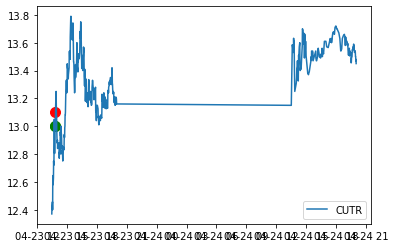

now=2020-04-23 10:21:51.810817
LYTS analysis for run 424 with profit 22.4


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1299.2,-1299.2,buy,2020-04-23 14:21:51.810817,5.8,"[5.24, 5.28, 5.3, 5.33, 5.39, 5.425, 5.5769]",[5.9],224,"{'avg': 5.5792, 'rsi': 67.06265161386169, 'macd': [0.027630021422261564, 0.02740335015603179, 0.04047472337871749, 0.057434064526078465, 0.07245994075804418], 'vwap': 5.8, 'sell_macd': [0.01609762968209516, 0.015908605475145166, 0.024385877450572302, 0.03535016889310505, 0.044993121070493025], 'slow macd': [0.015649592694307657, 0.016269458188905794, 0.019532645981914953, 0.023943067624371928, 0.02844231109849993], 'macd_signal': [0.030087499129613053, 0.0295506693348968, 0.03173548014366094, 0.03687519702014445, 0.043992145767724394], 'resistances': [5.9], 'sell_macd_signal': [0.01813756603638185, 0.017691773924134513, 0.01903059462942207, 0.022294509482158668, 0.02683423179982554]}",7.07,5.38
1,-178.2,1121.0,sell,2020-04-23 16:05:59.580732,5.9,None,None,190,"{'avg': 5.7185, 'rsi': 78.70972600652185, 'vwap': 5.9, 'reasons': 'rsi max', 'movement': 0.01724137931034492, 'sell_macd': [0.009586468788568503, 0.010075380988162408, 0.01032550242955832, 0.011830460664028486, 0.016080681877070013], 'sell_macd_signal': [0.013581552809822192, 0.012880318445490235, 0.012369355242303853, 0.012261576326648779, 0.013025397436733026]}",7.07,5.38
2,22.4,200.6,sell,2020-04-23 16:05:59.879820,5.9,None,None,34,"{'avg': 5.7185, 'rsi': 78.70972600652185, 'vwap': 5.9, 'reasons': 'rsi max', 'movement': 0.01724137931034492, 'sell_macd': [0.009586468788568503, 0.010075380988162408, 0.01032550242955832, 0.011830460664028486, 0.016080681877070013], 'sell_macd_signal': [0.013581552809822192, 0.012880318445490235, 0.012369355242303853, 0.012261576326648779, 0.013025397436733026]}",7.07,5.38


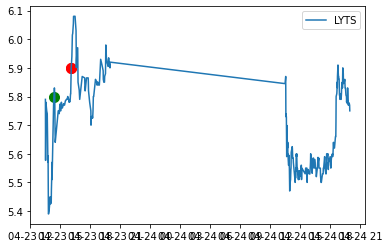

now=2020-04-23 09:59:18.989635
PGEN analysis for run 424 with profit 75.05


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2749.20,-2749.20,buy,2020-04-23 13:59:18.989635,3.48,"[3.29, 3.3, 3.3, 3.37]","[3.52, 3.6, 3.65]",790,"{'avg': 3.4045, 'rsi': 68.34012139834891, 'macd': [0.021568968770432573, 0.022532746506856327, 0.023031059588022096, 0.023557874001038037, 0.02569645652974195], 'vwap': 3.47, 'sell_macd': [0.012638546165249842, 0.013238150022498285, 0.013533449781101048, 0.01384753466077715, 0.01521113931168383], 'slow macd': [0.019980316391175812, 0.020461360913292648, 0.020871212173483755, 0.021294875868407726, 0.0220504419054115], 'macd_signal': [0.02160737155844654, 0.021792446548128497, 0.022040169156107216, 0.02234371012509338, 0.023014259406023092], 'resistances': [3.52, 3.6, 3.65], 'sell_macd_signal': [0.01285851767001221, 0.012934444140509425, 0.01305424526862775, 0.01321290314705763, 0.013612550379982869]}",3.84,3.36
1,-1346.95,1402.25,sell,2020-04-23 14:09:59.143164,3.55,None,None,395,"{'avg': 3.4331, 'rsi': 71.30309843580135, 'vwap': 3.5446, 'reasons': 'scale-out', 'movement': 0.020114942528735587, 'sell_macd': [0.014712772440283128, 0.01619079686510272, 0.016664701652428615, 0.017856514452260885, 0.020111738524179135], 'sell_macd_signal': [0.014647186794684793, 0.014955908808768379, 0.015297667377500426, 0.015809436792452516, 0.01666989713879784]}",3.84,3.36
2,75.05,1422.00,sell,2020-04-23 15:31:03.843055,3.60,None,None,395,"{'avg': 3.5392, 'rsi': 39.13294175065227, 'vwap': 3.61, 'reasons': 'below cost & macd negative', 'movement': -0.005509641873278242, 'sell_macd': [0.0029364219166754246, 0.0031328780724821925, 0.002985533803338214, 0.0007540248429229734, -0.000994605838477547], 'sell_macd_signal': [0.0041199608487780095, 0.003922544293518846, 0.0037351421954827197, 0.0031389187249707706, 0.002312213812281107]}",3.84,3.36


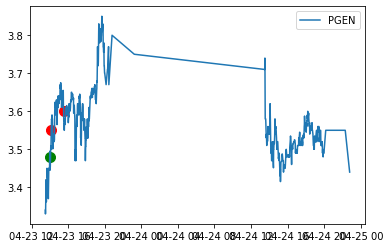

now=2020-04-23 10:46:20.229787
DKL analysis for run 424 with profit -50.17


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2681.50,-2681.50,buy,2020-04-23 14:46:20.229787,15.50,[15.01],[15.78],173,"{'avg': 15.0679, 'rsi': 65.77909602869396, 'macd': [0.030414422454711598, 0.027817553522991645, 0.03902721400642584, 0.052949002544655954, 0.06923588527352997], 'vwap': 15.545, 'sell_macd': [0.016984490321650725, 0.015367044721250167, 0.02273829432196095, 0.031823186292358585, 0.0423851386551064], 'slow macd': [0.10797462475174058, 0.10561343338077656, 0.1059910602987646, 0.1072885234323504, 0.10951015820909937], 'macd_signal': [0.0209355985716048, 0.02231198956188217, 0.025655034450790905, 0.031113828069563913, 0.038738239510357125], 'resistances': [15.78], 'sell_macd_signal': [0.009997750650675204, 0.011071609464790197, 0.013404946436224347, 0.017088594407451196, 0.022147903256982238]}",17.21,14.99
1,-50.17,2631.33,sell,2020-04-23 15:12:22.954951,15.21,None,None,173,"{'avg': 15.0985, 'rsi': 38.039812012877036, 'vwap': 15.3154, 'reasons': 'below cost & macd negative', 'movement': -0.021550337729173308, 'sell_macd': [0.02097166591816091, 0.013641706135032905, 0.007233403626944579, 0.0026654613657477455, -0.008720798336039337], 'sell_macd_signal': [0.029308032436882535, 0.026174767176512608, 0.022386494466599002, 0.01844228784642875, 0.013009670609935135]}",17.21,14.99


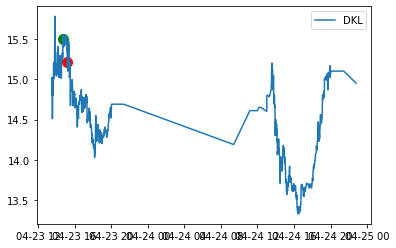

now=2020-04-23 10:26:36.872463
ERI analysis for run 424 with profit -25.92


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3471.12,-3471.12,buy,2020-04-23 14:26:36.872463,16.07,"[15.5651, 15.675, 15.7001]",[16.49],216,"{'avg': 15.7406, 'rsi': 68.68295468065662, 'macd': [0.011222887765439893, 0.02668117485329269, 0.03493845191809619, 0.04260511113504428, 0.05769887421231168], 'vwap': 16.0625, 'sell_macd': [0.0034216760887133546, 0.013729847367812908, 0.01927219060648966, 0.02437957247290612, 0.034276498960077006], 'slow macd': [0.07795743150327539, 0.07950242579529743, 0.08008500163006893, 0.08081277731550784, 0.08327233778849319], 'macd_signal': [0.010713084827564504, 0.01390670283271014, 0.01811305264978735, 0.023011464346838737, 0.029948946319933327], 'resistances': [16.15, 16.25, 16.49], 'sell_macd_signal': [0.001895654810031625, 0.004262493321587882, 0.007264432778568237, 0.010687460717435813, 0.015405268365964052]}",17.39,15.63
1,-25.92,3445.20,sell,2020-04-23 15:01:07.252919,15.95,None,None,216,"{'avg': 15.8377, 'rsi': 34.29440975827837, 'vwap': 15.9734, 'reasons': 'below cost & macd negative', 'movement': -0.006533914125700088, 'sell_macd': [0.01642044538623111, 0.014612712408968775, 0.010640287849948749, 0.0025028104292843523, -0.005169286397588735], 'sell_macd_signal': [0.024271067907870196, 0.022339396808089912, 0.019999575016461678, 0.016500222099026213, 0.012166320399703223]}",17.39,15.63


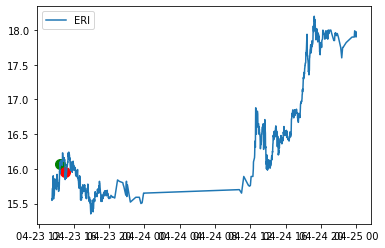

now=2020-04-23 10:24:33.764582
ENDP analysis for run 424 with profit -63.49


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3337.76,-3337.76,buy,2020-04-23 14:24:33.764582,3.68,"[3.56, 3.5901]",[3.71],907,"{'avg': 3.5875, 'rsi': 66.86586689808694, 'macd': [0.009625543849742346, 0.009919286811148176, 0.011232968199017535, 0.012931915517729653, 0.015711068938171202], 'vwap': 3.676, 'sell_macd': [0.004113122915739176, 0.0043961026157033345, 0.005338734815471646, 0.006523399713791456, 0.008400756781134167], 'slow macd': [0.02958701234402783, 0.02930049107399446, 0.0292299243380314, 0.029278187530033417, 0.02959563689215905], 'macd_signal': [0.014897910811797232, 0.013902186011667421, 0.013368342449137444, 0.013281057062855886, 0.01376705943791895], 'resistances': [3.71], 'sell_macd_signal': [0.0072727407673076425, 0.006697413136986781, 0.0064256774726837535, 0.006445221920905294, 0.006836328892951068]}",4.0,3.58
1,-63.49,3274.27,sell,2020-04-23 14:32:52.491239,3.61,None,None,907,"{'avg': 3.5911, 'rsi': 44.52416936515205, 'vwap': 3.61, 'reasons': 'below cost & macd negative', 'movement': -0.01902173913043486, 'sell_macd': [0.005798093156784034, 0.003969768015670283, 0.002493543645767815, 0.0010511149984959722, -8.65062201378386e-05], 'sell_macd_signal': [0.007011002586805882, 0.006402755672578762, 0.005620913267216573, 0.004706953613472452, 0.0037482616467503943]}",4.0,3.58


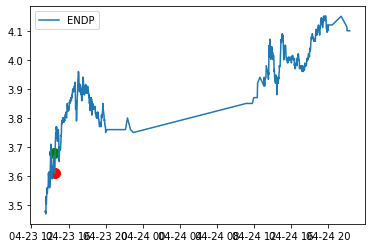

now=2020-04-23 10:20:44.944579
BVN analysis for run 424 with profit 30.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4010.0,-4010.0,buy,2020-04-23 14:20:44.944579,8.02,[7.84],"[8.16, 8.18]",500,"{'avg': 7.8332, 'rsi': 74.15164048252169, 'macd': [0.03429099279703518, 0.03782881218528189, 0.03977065002866276, 0.04203538737001633, 0.0465216016702783], 'vwap': 8.02, 'sell_macd': [0.019864685599848997, 0.022180820032265736, 0.023437797251911974, 0.024892093822390216, 0.027779960061433684], 'slow macd': [0.04123579972544178, 0.04216229778935876, 0.04286730492806967, 0.04368727782149673, 0.04501155151861358], 'macd_signal': [0.024646800678856634, 0.027283202980141686, 0.0297806923898459, 0.032231631385879984, 0.03508962544275965], 'resistances': [8.16, 8.18], 'sell_macd_signal': [0.013244235916090077, 0.015031552739325209, 0.01671280164184256, 0.018348660077952092, 0.02023492007464841]}",8.59,7.83
1,30.0,4040.0,sell,2020-04-23 14:27:10.907337,8.08,None,None,500,"{'avg': 7.8472, 'rsi': 79.64048228204027, 'vwap': 8.101, 'reasons': 'rsi max', 'movement': 0.01122194513715709, 'sell_macd': [0.02955176640445334, 0.030698098749329716, 0.033010849943397425, 0.034903761913535725, 0.037483904203079454], 'sell_macd_signal': [0.024562768095048756, 0.02578983422590495, 0.027234037369403444, 0.028767982278229902, 0.030511166663199814]}",8.59,7.83


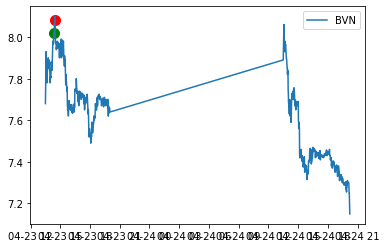

now=2020-04-23 10:54:40.295717
PUMP analysis for run 424 with profit 51.52


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2811.52,-2811.52,buy,2020-04-23 14:54:40.295717,3.82,[3.73],"[3.85, 3.85, 3.85, 3.85, 3.85, 3.85]",736,"{'avg': 3.6216, 'rsi': 70.55275402186575, 'macd': [0.02085428986261917, 0.017801658687532473, 0.018398011371580925, 0.02104873770385174, 0.02527880833222529], 'vwap': 3.8167, 'sell_macd': [0.011238929418782906, 0.009276206277993637, 0.009704263489352716, 0.011470226725615262, 0.014255779549642966], 'slow macd': [0.029704585657000848, 0.02914979904075432, 0.02923250068004002, 0.029741643610578183, 0.03064231186676647], 'macd_signal': [0.028750009817597247, 0.02656033959158429, 0.02492787394758362, 0.02415204669883724, 0.02437739902551485], 'resistances': [3.85, 3.85, 3.85], 'sell_macd_signal': [0.016516449773582485, 0.015068401074464716, 0.013995573557442315, 0.013490504191076905, 0.013643559262790117]}",4.21,3.69
1,51.52,2863.04,sell,2020-04-23 15:13:57.681094,3.89,None,None,736,"{'avg': 3.6477, 'rsi': 71.28807558831046, 'vwap': 3.9017, 'reasons': 'bail', 'movement': 0.02094240837696337, 'sell_macd': [0.015838548010302045, 0.01567309219682489, 0.015860099456494137, 0.01761802589965855, 0.01901877344108982], 'sell_macd_signal': [0.01656144677913422, 0.016383775862672353, 0.01627904058143671, 0.016546837645081077, 0.017041224804282825]}",4.21,3.69


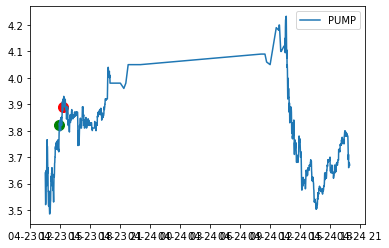

now=2020-04-23 10:32:58.890226
HP analysis for run 424 with profit -15.45


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5991.51,-5991.51,buy,2020-04-23 14:32:58.890226,19.39,"[18.94, 19.12]",[19.8859],309,"{'avg': 19.1725, 'rsi': 63.46426783194315, 'macd': [0.034876326354119414, 0.04396736082303221, 0.04899347203573967, 0.05117639709371957, 0.05589320279904797], 'vwap': 19.3975, 'sell_macd': [0.01856912916438702, 0.024605746876463996, 0.027951088640726596, 0.029415626526635208, 0.03251246609323388], 'slow macd': [0.08034346815535542, 0.08139711632223268, 0.08191645097504718, 0.08202333751332347, 0.0827102037966192], 'macd_signal': [0.032454002297094595, 0.03475667400228212, 0.03760403360897363, 0.04031850630592282, 0.04343344560454785], 'resistances': [19.8859], 'sell_macd_signal': [0.016375725658694933, 0.018021729902248745, 0.020007601649944314, 0.021889206625282494, 0.02401385851887277]}",20.31,19.08
1,-15.45,5976.06,sell,2020-04-23 15:38:40.757585,19.34,None,None,309,"{'avg': 19.3344, 'rsi': 33.05093070555202, 'vwap': 19.3907, 'reasons': 'below cost & macd negative', 'movement': 0.0, 'sell_macd': [0.004546653418216806, 0.0009728640929651533, -6.359590258853132e-06, -0.005184892855233159, -0.013828101985666308], 'sell_macd_signal': [0.00866816123993684, 0.007129101810542503, 0.005702009530382231, 0.003524629053259153, 5.408284547406099e-05]}",20.31,19.08


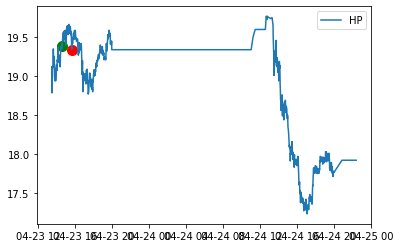

now=2020-04-23 10:13:40.894976
SSL analysis for run 424 with profit 42.24


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3600.96,-3600.96,buy,2020-04-23 14:13:40.894976,3.41,"[3.3, 3.335, 3.34, 3.35]","[3.49, 3.49]",1056,"{'avg': 3.3519, 'rsi': 72.62049228389644, 'macd': [0.011374865720314098, 0.011396399699739046, 0.012081118348009401, 0.013277623062773802, 0.015659185183312996], 'vwap': 3.4094, 'sell_macd': [0.00577311837783423, 0.005840162350807532, 0.006336038662853927, 0.007159630092203884, 0.008747368477513007], 'slow macd': [0.021597826163378464, 0.02150801766644861, 0.021550927933501107, 0.021715875079743707, 0.022152772274140364], 'macd_signal': [0.012787520387531118, 0.012509296249972704, 0.012423660669580044, 0.012594453148218795, 0.013207399555237635], 'resistances': [3.49, 3.49], 'sell_macd_signal': [0.006481272831877066, 0.00635305073566316, 0.006349648321101313, 0.0065116446753218276, 0.006958789435760063]}",3.68,3.32
1,42.24,3643.20,sell,2020-04-23 14:22:00.763881,3.45,None,None,1056,"{'avg': 3.3644, 'rsi': 78.15839338811436, 'vwap': 3.4589, 'reasons': 'rsi max', 'movement': 0.014662756598240416, 'sell_macd': [0.010203887337565831, 0.011910465516171254, 0.012758312596692356, 0.013996137430907662, 0.015594492659765091], 'sell_macd_signal': [0.008229228905556215, 0.008965476227679223, 0.009724043501481849, 0.010578462287367012, 0.011581668361846629]}",3.68,3.32


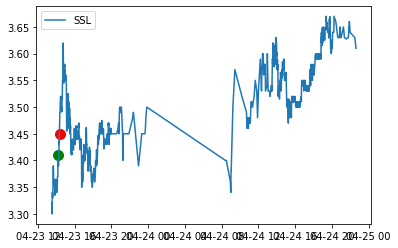

now=2020-04-23 10:06:48.969256
IMV analysis for run 424 with profit 9.48


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1104.42,-1104.42,buy,2020-04-23 14:06:48.969256,2.33,"[2.01, 2.165]",[2.35],474,"{'avg': 2.2078, 'rsi': 68.36450144258656, 'macd': [0.04120339602102829, 0.04867821707701969, 0.0531821000459356, 0.05370357986436325, 0.055103558868950575], 'vwap': 2.33, 'sell_macd': [0.024148493140376814, 0.02897040732015288, 0.03183202346906722, 0.032084814968623476, 0.032909265293360246], 'slow macd': [0.03162703238469167, 0.03387176883496368, 0.03572288898559739, 0.036887437530445766, 0.03822133455226684], 'macd_signal': [0.039214885849706546, 0.04110755209516918, 0.043522461685322464, 0.045558685321130624, 0.047467660030694615], 'resistances': [2.35], 'sell_macd_signal': [0.0231088552154562, 0.024281165636395534, 0.025791337202929872, 0.02705003275606859, 0.02822187926352692]}",2.93,2.13
1,9.48,1113.90,sell,2020-04-23 14:26:42.559068,2.35,None,None,474,"{'avg': 2.2337, 'rsi': 66.35033874565568, 'vwap': 2.3799, 'reasons': 'bail', 'movement': 0.02141630901287556, 'sell_macd': [0.018559328258285213, 0.01741392991424373, 0.016445906140779787, 0.01599749922456395, 0.01699357826095982], 'sell_macd_signal': [0.02354037235150274, 0.022315083864050938, 0.02114124831939671, 0.020112498500430155, 0.01948871445253609]}",2.93,2.13


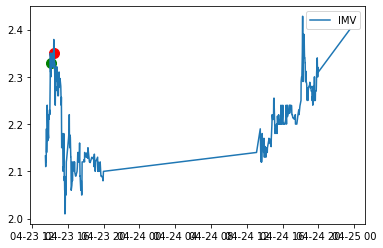

now=2020-04-23 10:32:15.051231
PRVB analysis for run 424 with profit -54.6


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2103.92,-2103.92,buy,2020-04-23 14:32:15.051231,11.56,"[11.048, 11.38]",[11.99],182,"{'avg': 11.2393, 'rsi': 69.31753012671888, 'macd': [0.08169564490447101, 0.08178050819554805, 0.08171274572336706, 0.0847170600745244, 0.09089175581888576], 'vwap': 11.56, 'sell_macd': [0.04813702078408433, 0.048081885240979005, 0.04793396293153407, 0.04979358239259746, 0.05371284973377932], 'slow macd': [0.06628418055955265, 0.06767984919637904, 0.06901560055045941, 0.0709338338425578, 0.07354483722910032], 'macd_signal': [0.0800653488444165, 0.08040838071464282, 0.08066925371638767, 0.08147881498801501, 0.08336140315418916], 'resistances': [11.73, 11.99], 'sell_macd_signal': [0.047557781202296444, 0.04766260201003296, 0.04771687419433318, 0.04813221583398604, 0.049248342613944694]}",13.13,11.04
1,-54.60,2049.32,sell,2020-04-23 14:53:57.612584,11.26,None,None,182,"{'avg': 11.2897, 'rsi': 42.66164705697454, 'vwap': 11.3059, 'reasons': 'below cost & macd negative', 'movement': -0.02249134948096884, 'sell_macd': [0.03187584433348434, 0.021918844587194286, 0.011018340309732366, 0.002900826063532591, -0.005020624336928847], 'sell_macd_signal': [0.04125451617085861, 0.03738738185412575, 0.03211357354524707, 0.026271024048904173, 0.02001269437173757]}",13.13,11.04


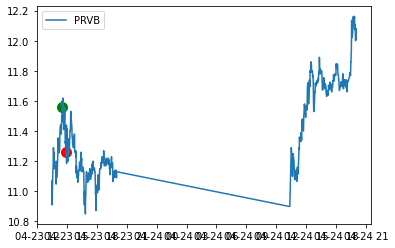

now=2020-04-23 10:25:31.716781
RUSL analysis for run 424 with profit -13.12


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4221.36,-4221.36,buy,2020-04-23 14:25:31.716781,12.87,"[12.602, 12.71]","[13.0, 13.06, 13.06]",328,"{'avg': 12.7012, 'rsi': 75.03375385972332, 'macd': [0.04848804827855524, 0.05008521129557586, 0.053158940596141235, 0.05416361237753975, 0.0559289408401451], 'vwap': 12.87, 'sell_macd': [0.027138572119183024, 0.028239757976940894, 0.030289516333935396, 0.030973879776606594, 0.0321438528517195], 'slow macd': [0.08528532470971051, 0.08521574126227449, 0.08549523967187156, 0.08545571343508307, 0.08560254561237812], 'macd_signal': [0.04581069086789415, 0.04666559495343049, 0.04796426408197264, 0.049204133741086065, 0.050549095160897874], 'resistances': [13.0, 13.06, 13.06], 'sell_macd_signal': [0.024892842407582376, 0.02556222552145408, 0.02650768368395034, 0.02740092290248159, 0.02834950889232917]}",13.74,12.58
1,-13.12,4208.24,sell,2020-04-23 14:56:33.512652,12.83,None,None,328,"{'avg': 12.7328, 'rsi': 44.07710834754161, 'vwap': 12.83, 'reasons': 'below cost & macd negative', 'movement': -0.003108003108003042, 'sell_macd': [0.005364250132153359, 0.004182253591622498, 0.0021679413056023833, 0.0005701922346066368, -0.0012016926549307527], 'sell_macd_signal': [0.014299830790192652, 0.012276315350478621, 0.010254640541503374, 0.008317750880124026, 0.00641386217311307]}",13.74,12.58


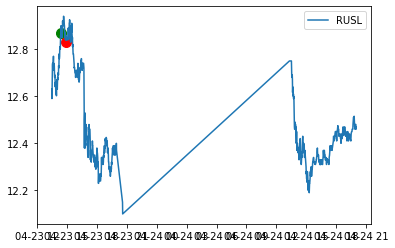

now=2020-04-23 10:02:02.563223
SELB analysis for run 424 with profit 18.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1387.74,-1387.74,buy,2020-04-23 14:02:02.563223,3.03,[2.8327],[3.05],458,"{'avg': 2.8816, 'rsi': 72.05846674124238, 'macd': [0.021870681500518963, 0.0301850160025654, 0.04035168815086276, 0.04514493056732549, 0.04950265689854483], 'vwap': 3.0225, 'sell_macd': [0.012217910989008818, 0.01763981852436336, 0.02423819038925812, 0.027298763395809278, 0.030056368811358425], 'slow macd': [0.024307464961617065, 0.02620458422256311, 0.028709363543853783, 0.03042414153830153, 0.0321770434171782], 'macd_signal': [0.025421835510639913, 0.02637447160902501, 0.029169914917392563, 0.03236491804737915, 0.035792465817612286], 'resistances': [3.05], 'sell_macd_signal': [0.014645873259784458, 0.015244662312700238, 0.017043367928011813, 0.019094447021571308, 0.02128683137952873]}",3.65,2.82
1,18.32,1406.06,sell,2020-04-23 14:19:06.296407,3.07,None,None,458,"{'avg': 2.9163, 'rsi': 67.7873289201149, 'vwap': 3.1004, 'reasons': 'bail', 'movement': 0.023102310231023198, 'sell_macd': [0.026854792716217712, 0.024506846221426848, 0.02384991588494767, 0.022508802429444863, 0.02428833996503421], 'sell_macd_signal': [0.030498286896126568, 0.029299998761186625, 0.028209982185938835, 0.027069746234640042, 0.026513464980718875]}",3.65,2.82


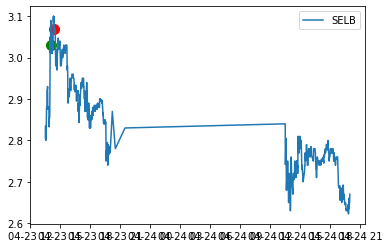

now=2020-04-23 09:53:41.509690
NNA analysis for run 424 with profit -39.05


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2279.10,-2279.10,buy,2020-04-23 13:53:41.509690,6.42,"[6.0167, 6.05, 6.15, 6.1898]",[6.5],355,"{'avg': 6.2925, 'rsi': 75.74443746912173, 'macd': [0.07179371928595923, 0.07390258622408652, 0.07710580007903989, 0.07808261093315938, 0.08019170649199214], 'vwap': 6.4298, 'sell_macd': [0.043357837055522985, 0.044574944505424874, 0.04650288609618691, 0.046975270633193844, 0.04818783948497618], 'slow macd': [0.05082176033765151, 0.0525824692865795, 0.054598087604986745, 0.056234051379570715, 0.058097072746943645], 'macd_signal': [0.06257926714220145, 0.06484393095857846, 0.06729630478267075, 0.06945356601276848, 0.07160119410861321], 'resistances': [6.5], 'sell_macd_signal': [0.03788437056640094, 0.03922248535420573, 0.04067856550260197, 0.04193790652872034, 0.04318789311997151]}",7.23,6.16
1,-39.05,2240.05,sell,2020-04-23 14:25:38.041708,6.31,None,None,355,"{'avg': 6.3506, 'rsi': 40.383839568639225, 'vwap': 6.34, 'reasons': 'below cost & macd negative', 'movement': -0.013966219789107021, 'sell_macd': [0.020221573583168784, 0.01651192099049137, 0.008217231684632509, 0.003382185060786469, -0.0011306069196237445], 'sell_macd_signal': [0.02575848446945505, 0.023909171773662315, 0.020770783755856354, 0.01729306401684238, 0.013608329829549154]}",7.23,6.16


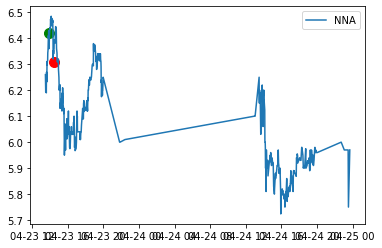

now=2020-04-23 10:15:56.273481
TALO analysis for run 424 with profit 25.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2120.0,-2120.0,buy,2020-04-23 14:15:56.273481,8.48,"[7.51, 7.95, 8.07, 8.12]",[9.0],250,"{'avg': 8.2795, 'rsi': 70.95374118390332, 'macd': [0.053944475873874964, 0.057784778028681316, 0.06013504577927087, 0.0644022350906539, 0.07187764284070397], 'vwap': 8.48, 'sell_macd': [0.026604252058220368, 0.029412097652945945, 0.031218053991004524, 0.03424583744935106, 0.039329229268199484], 'slow macd': [0.11719408840427903, 0.1171405396313272, 0.11690392312389619, 0.1171230073797549, 0.11811285977608321], 'macd_signal': [0.061551203322429714, 0.060797918263680036, 0.060665343766798205, 0.06141272203156935, 0.06350570619339627], 'resistances': [9.0], 'sell_macd_signal': [0.03037776401959854, 0.03018463074626802, 0.03039131539521532, 0.031162219806042467, 0.03279562169847387]}",9.62,8.1
1,25.0,2145.0,sell,2020-04-23 14:21:39.574238,8.58,None,None,250,"{'avg': 8.2951, 'rsi': 78.44193385211398, 'vwap': 8.6799, 'reasons': 'rsi max', 'movement': 0.02357311320754711, 'sell_macd': [0.042038514376596225, 0.04475328496219788, 0.04689527132809168, 0.05055272471283878, 0.05897473092546157], 'sell_macd_signal': [0.03607539413068362, 0.037810972296986475, 0.039627832103207514, 0.04181281062513377, 0.04524519468519933]}",9.62,8.1


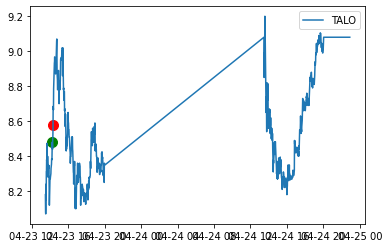

now=2020-04-23 10:23:21.104405
NWL analysis for run 424 with profit -5.28


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6668.64,-6668.64,buy,2020-04-23 14:23:21.104405,12.63,"[12.055, 12.1, 12.18, 12.38, 12.48]",[12.8],528,"{'avg': 12.4422, 'rsi': 69.35499721206503, 'macd': [0.028498780639440113, 0.029518535957025804, 0.031177677177847585, 0.03212227298130621, 0.03568715832041214], 'vwap': 12.6294, 'sell_macd': [0.015085246359751281, 0.01582585208816134, 0.01697663769356872, 0.01765287793552872, 0.02002848230672427], 'slow macd': [0.043933049764003584, 0.04414986599140924, 0.04451863635338249, 0.04478671554470104, 0.04560147098534095], 'macd_signal': [0.03369293373508255, 0.0328580541794712, 0.032521978779146477, 0.03244203761957842, 0.03309106175974517], 'resistances': [12.8], 'sell_macd_signal': [0.018274059265801206, 0.017784417830273232, 0.01762286180293233, 0.01762886502945161, 0.01810878848490614]}",13.17,12.45
1,-5.28,6663.36,sell,2020-04-23 14:54:45.972218,12.62,None,None,528,"{'avg': 12.5058, 'rsi': 38.8929914444764, 'vwap': 12.62, 'reasons': 'below cost & macd negative', 'movement': -0.0007917656373714618, 'sell_macd': [0.008313491117210248, 0.006596216563186985, 0.0049126751371524335, 0.0030175431800198993, -5.681345125196913e-05], 'sell_macd_signal': [0.015006757252423097, 0.013324649114575874, 0.011642254319091185, 0.009917312091276928, 0.007922486982771149]}",13.17,12.45


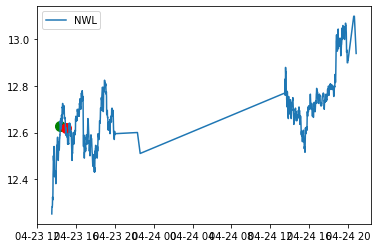

now=2020-04-23 09:47:12.275068
AERI analysis for run 424 with profit -36.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1886.28,-1886.28,buy,2020-04-23 13:47:12.275068,14.29,"[13.65, 13.65]",[14.56],132,"{'avg': 13.9276, 'rsi': 71.92734470138075, 'macd': [0.09496254546502136, 0.10598181853389121, 0.11221080092649416, 0.12259292900130703, 0.1309254461083409], 'vwap': 14.285, 'sell_macd': [0.06081450959774415, 0.06762214486530382, 0.07126936527034644, 0.07760136343959445, 0.08256653911122314], 'slow macd': [0.03123046011366526, 0.03598015389620102, 0.040052574839036126, 0.045094730092975155, 0.04998142354317281], 'macd_signal': [0.04927282559489504, 0.060614624182694275, 0.07093385953145426, 0.08126567342542482, 0.09119762796200803], 'resistances': [14.44, 14.56], 'sell_macd_signal': [0.03160729926412102, 0.03881026838435758, 0.04530208776155535, 0.05176194289716317, 0.05792286213997516]}",16.43,13.58
1,-36.96,1849.32,sell,2020-04-23 14:08:30.563016,14.01,None,None,132,"{'avg': 14.0146, 'rsi': 46.73554604810803, 'vwap': 14.05, 'reasons': 'below cost & macd negative', 'movement': -0.016794961511546427, 'sell_macd': [0.012703990558954104, 0.010593588083271044, 0.004915435659578193, 0.0001673242169673017, -0.002495714883989919], 'sell_macd_signal': [0.032173162980812645, 0.027857248001304326, 0.0232688855329591, 0.01864857326976074, 0.014419715639010608]}",16.43,13.58


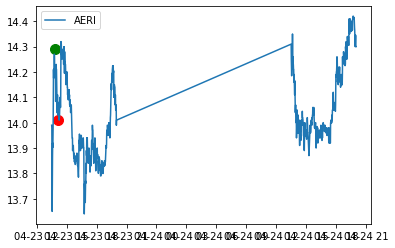

now=2020-04-23 10:35:19.265300
TUP analysis for run 424 with profit -56.35


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2411.78,-2411.78,buy,2020-04-23 14:35:19.265300,2.14,"[2.029, 2.03, 2.04]","[2.17, 2.2, 2.2, 2.2, 2.2, 2.2001, 2.21, 2.21, 2.24, 2.24, 2.24, 2.24, 2.24, 2.24, 2.24, 2.24, 2.25]",1127,"{'avg': 2.0569, 'rsi': 75.37950192651101, 'macd': [0.012043791603988385, 0.011763393750604312, 0.013276319720167962, 0.016033440411761912, 0.018385789211024406], 'vwap': 2.1447, 'sell_macd': [0.00720800124335419, 0.0070054261333512, 0.007972180253694727, 0.00974403826625192, 0.011242316740111669], 'slow macd': [0.012451217030371442, 0.012513286634708631, 0.01292462970269792, 0.013627869159168249, 0.01432824601350724], 'macd_signal': [0.010585801626929736, 0.01082132005166465, 0.011312319985365313, 0.012256544070644634, 0.013482393098720588], 'resistances': [2.17, 2.2, 2.2, 2.2, 2.2, 2.2001, 2.21, 2.21, 2.24, 2.24, 2.24, 2.24, 2.24, 2.24, 2.24, 2.24, 2.25], 'sell_macd_signal': [0.006292513343768688, 0.00643509590168519, 0.006742512772087097, 0.0073428178709200615, 0.008122717644758384]}",2.4,2.06
1,-56.35,2355.43,sell,2020-04-23 14:54:00.583288,2.09,None,None,1127,"{'avg': 2.0642, 'rsi': 41.454986126050464, 'vwap': 2.0911, 'reasons': 'below cost & macd negative', 'movement': -0.02499184035063173, 'sell_macd': [0.004559682154124722, 0.003157819673806017, 0.0020192538492227463, 0.0006538875722847948, -0.0004237210535409375], 'sell_macd_signal': [0.007237945016643314, 0.006421919948075855, 0.005541386728305233, 0.004563886897101145, 0.003566365306972728]}",2.4,2.06


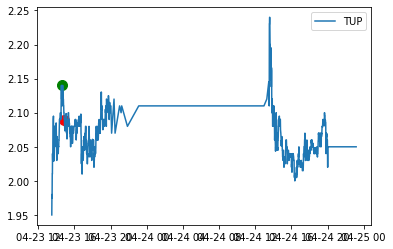

now=2020-04-23 10:23:42.060559
INDL analysis for run 424 with profit 76.16


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4596.80,-4596.80,buy,2020-04-23 14:23:42.060559,16.90,"[15.08, 15.6, 15.7583, 15.81, 16.2, 16.4, 16.61]","[18.0, 18.2, 18.25]",272,"{'avg': 16.7876, 'rsi': 75.03363099741517, 'macd': [0.04964127924633743, 0.05332360923405943, 0.056430578777327156, 0.06217842581234123, 0.07235490510402087], 'vwap': 16.9083, 'sell_macd': [0.022765714253058178, 0.02556853854326846, 0.02796075826884703, 0.03203832223333691, 0.038955406851986396], 'slow macd': [0.12978305871209272, 0.12927148982060643, 0.12876041186034826, 0.12887755219062313, 0.13005869161133177], 'macd_signal': [0.06180363519710937, 0.06010763000449938, 0.05937221975906494, 0.0599334609697202, 0.06241774979658034], 'resistances': [18.0, 18.2, 18.25], 'sell_macd_signal': [0.02909291223922545, 0.028388037500034054, 0.02830258165379665, 0.029049729769704703, 0.031030865186161043]}",18.0,16.6
1,76.16,4672.96,sell,2020-04-23 14:46:22.567945,17.18,None,None,272,"{'avg': 16.8323, 'rsi': 80.66061692276296, 'vwap': 17.2, 'reasons': 'rsi max', 'movement': 0.014749262536873156, 'sell_macd': [0.058081284279989376, 0.058379919981927486, 0.0635115852044521, 0.06726208297259717, 0.06931101522085825], 'sell_macd_signal': [0.054214917015446354, 0.05504791760874258, 0.056740651127884484, 0.058844937496827024, 0.06093815304163327]}",18.0,16.6


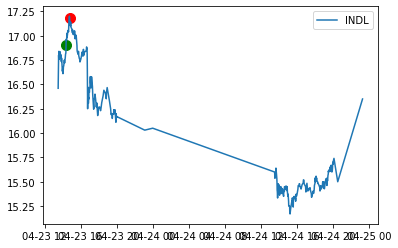

now=2020-04-23 10:23:22.952414
CLF analysis for run 424 with profit 16.32


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1093.44,-1093.44,buy,2020-04-23 14:23:22.952414,4.02,"[3.7, 3.7, 3.855]","[4.09, 4.13, 4.13, 4.15, 4.15, 4.15, 4.15, 4.15, 4.17]",272,"{'avg': 3.8822, 'rsi': 75.0293903270946, 'macd': [0.02665271247153589, 0.02804514922920598, 0.030411928464084692, 0.034815394491820584, 0.03656836195523949], 'vwap': 4.0198, 'sell_macd': [0.014899520792730048, 0.01583152753833783, 0.017391123346105708, 0.020266248347663662, 0.02139665421449255], 'slow macd': [0.034157585226032516, 0.03458612298020736, 0.035244947802452575, 0.036375286117037664, 0.03709636061419497], 'macd_signal': [0.02680452052701727, 0.02705264626745501, 0.027724502706780944, 0.029142681063788874, 0.030627817242078997], 'resistances': [4.09, 4.13, 4.15, 4.15, 4.15, 4.15, 4.17], 'sell_macd_signal': [0.014894770338068354, 0.01508212177812225, 0.015543922091718941, 0.016488387342907886, 0.01747004071722482]}",5.07,3.67
1,16.32,1109.76,sell,2020-04-23 14:45:28.145433,4.08,None,None,272,"{'avg': 3.9257, 'rsi': 79.45732231959417, 'vwap': 4.0899, 'reasons': 'rsi max', 'movement': 0.017388059701492667, 'sell_macd': [0.009962308553986166, 0.011019862026080407, 0.011700814575426044, 0.013378169619390867, 0.01580496355469574], 'sell_macd_signal': [0.010381538060828784, 0.010509202853879109, 0.010747525198188496, 0.011273654082428971, 0.012179915976882325]}",5.07,3.67


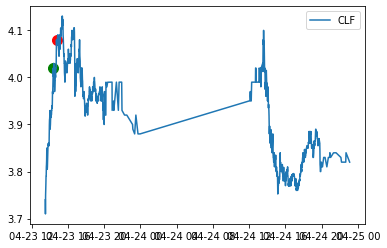

now=2020-04-23 10:24:13.859437
ERX analysis for run 424 with profit 130.26


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6668.31,-6668.31,buy,2020-04-23 14:24:13.859437,13.31,[13.1401],[13.53],501,"{'avg': 13.0707, 'rsi': 67.09325322813653, 'macd': [0.05790098931850984, 0.05890590224541903, 0.060617376450315064, 0.06366064112423331, 0.06611720870494686], 'vwap': 13.31, 'sell_macd': [0.03234354391769756, 0.03304912154861306, 0.03420867396817506, 0.03622639437344155, 0.037847651905163815], 'slow macd': [0.08933478503485759, 0.08942768699580483, 0.08969000473437383, 0.09026770689251329, 0.09081477679987415], 'macd_signal': [0.06073412901424648, 0.06036848366048099, 0.0604182622184478, 0.0610667379996049, 0.06207683214067329], 'resistances': [13.53, 13.95, 13.95, 13.95, 13.99], 'sell_macd_signal': [0.03398813318691747, 0.033800330859256586, 0.03388199948104028, 0.034350878459520534, 0.03505023314864919]}",13.88,13.12
1,130.26,6798.57,sell,2020-04-23 14:44:32.271705,13.57,None,None,501,"{'avg': 13.1538, 'rsi': 75.47082083635357, 'vwap': 13.5796, 'reasons': 'bail', 'movement': 0.020285499624342566, 'sell_macd': [0.04529072751432395, 0.0453218448391155, 0.0442380161981859, 0.04385791574813602, 0.04558955285526345], 'sell_macd_signal': [0.047557012616971255, 0.047109979061400103, 0.04653558648875726, 0.046000052340633014, 0.045917952443559104]}",13.88,13.12


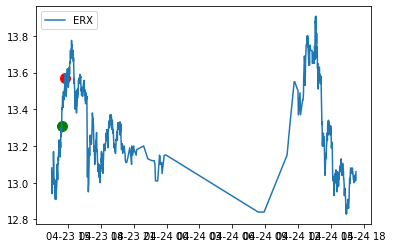

now=2020-04-23 09:48:40.216676
SNDE analysis for run 424 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1894.2,-1894.2,buy,2020-04-23 13:48:40.216676,3.3,[3.0],[3.5],574,"{'avg': 3.1551, 'rsi': 70.27544337933512, 'macd': [0.05080219459126578, 0.04966816454093337, 0.04303645251242871, 0.049794667276279014, 0.06041726098269962], 'vwap': 3.295, 'sell_macd': [0.03115059227802419, 0.03029281701582187, 0.02585957892818591, 0.030173165107584055, 0.0369815028433802], 'slow macd': [0.034929827510875366, 0.03563360704006069, 0.03518613093789957, 0.03721316531022101, 0.04020051174343564], 'macd_signal': [0.03551733613862369, 0.038347501819085625, 0.039285291957754244, 0.0413871670214592, 0.04519318581370728], 'resistances': [3.5], 'sell_macd_signal': [0.021397617777244107, 0.02317665762495966, 0.023713241885604912, 0.02500522653000074, 0.02740048179267663]}",3.79,3.13
1,0.0,1894.2,sell,2020-04-23 16:14:09.028471,3.3,None,None,574,"{'avg': 3.2678, 'rsi': 44.08220666657006, 'vwap': 3.3194, 'reasons': 'below cost & macd negative', 'movement': -0.02923976608187137, 'sell_macd': [0.002223955878252859, 0.0019721868160043066, 0.00045168901664149885, 0.00012335710783117904, -0.001515906160174385], 'sell_macd_signal': [0.004170037166781852, 0.0037304670966263427, 0.003074711480629374, 0.002484440606069735, 0.0016843712528209107]}",3.79,3.13


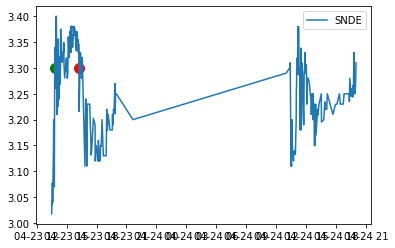

now=2020-04-23 10:31:53.787842
ADES analysis for run 424 with profit -16.15


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2219.01,-2219.01,buy,2020-04-23 14:31:53.787842,6.87,"[6.54, 6.54, 6.56, 6.57, 6.61]",[6.879],323,"{'avg': 6.7417, 'rsi': 67.07502485243934, 'macd': [0.02346523788327204, 0.030112791654734572, 0.035775544134886594, 0.03980447506224394, 0.04450173462000517], 'vwap': 6.8725, 'sell_macd': [0.01297326437616153, 0.017346691435384365, 0.021048755488864757, 0.023660120264448636, 0.026686376969261794], 'slow macd': [0.03766078712647758, 0.038896719189423834, 0.04013154238018046, 0.04120343442032848, 0.04252355031265154], 'macd_signal': [0.019119317552475514, 0.021318012372927325, 0.02420951872531918, 0.02732850999270413, 0.03076315491816434], 'resistances': [6.98], 'sell_macd_signal': [0.009918226716361958, 0.011403919660166439, 0.013332886825906103, 0.01539833351361461, 0.017655942204744045]}",7.77,6.59
1,-16.15,2202.86,sell,2020-04-23 15:47:10.484900,6.82,None,None,323,"{'avg': 6.7947, 'rsi': 43.16994462744303, 'vwap': 6.84, 'reasons': 'below cost & macd negative', 'movement': -0.0065359477124182904, 'sell_macd': [0.022521471027674878, 0.016784692716920624, 0.007940648673256057, 0.0014655409941246589, -0.0020405888986285703], 'sell_macd_signal': [0.02603933881340268, 0.02418840959410627, 0.020938857409936226, 0.017044194126773913, 0.013227237521693417]}",7.77,6.59


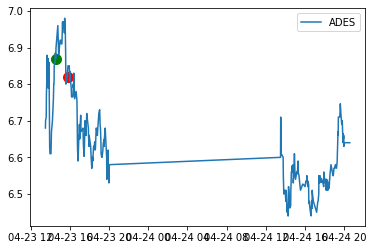

now=2020-04-23 10:35:41.457726
PPC analysis for run 424 with profit 66.78


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-9549.54,-9549.54,buy,2020-04-23 14:35:41.457726,20.02,"[19.73, 19.85]",[20.477],477,"{'avg': 19.7447, 'rsi': 76.79529823547112, 'macd': [0.05121355880443801, 0.05228522671813707, 0.0533267303346463, 0.05552931316427845, 0.05861647278106474], 'vwap': 20.02, 'sell_macd': [0.029165589205753406, 0.029903082397058967, 0.030608881216295458, 0.03206003768302068, 0.034073146128744014], 'slow macd': [0.09301117060534736, 0.09267998584340376, 0.09238699260845351, 0.09236950944010047, 0.0926055323076973], 'macd_signal': [0.043617723589868616, 0.045351224215522304, 0.046946325439347104, 0.048662922984333376, 0.05065363294367965], 'resistances': [20.477], 'sell_macd_signal': [0.023702506467505723, 0.02494262165341637, 0.02607587356599219, 0.02727270638939789, 0.028632794337267113]}",20.62,19.82
1,66.78,9616.32,sell,2020-04-23 14:45:38.320748,20.16,None,None,477,"{'avg': 19.775, 'rsi': 82.57692166752551, 'vwap': 20.1707, 'reasons': 'rsi max', 'movement': 0.007492507492507599, 'sell_macd': [0.0330581036194495, 0.03408864187654004, 0.03695284516938102, 0.04165543416160489, 0.04529829007552166], 'sell_macd_signal': [0.031448513387830876, 0.03197653908557271, 0.03297180030233437, 0.03470852707418847, 0.03682647967445511]}",20.62,19.82


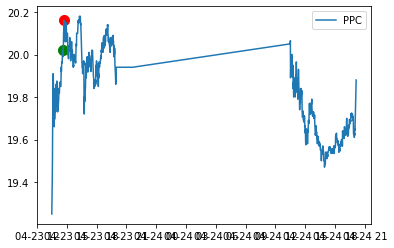

now=2020-04-23 10:47:43.674717
MG analysis for run 424 with profit -2.82


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-580.92,-580.92,buy,2020-04-23 14:47:43.674717,4.12,"[3.79, 3.92]",[4.1252],141,"{'avg': 3.7366, 'rsi': 77.50227055667776, 'macd': [0.06265944065965146, 0.06737152753368081, 0.07109328759129774, 0.07319901655277716, 0.07521120857042884], 'vwap': 4.125, 'sell_macd': [0.03608666789291437, 0.039140702799100424, 0.041531629962373806, 0.04285531827190692, 0.044109421912168045], 'slow macd': [0.0743385241413681, 0.07571717280530299, 0.07702441066395682, 0.07810392152765377, 0.07921209378325411], 'macd_signal': [0.0599021942354305, 0.06139606089508056, 0.06333550623432399, 0.06530820829801462, 0.06728880835249747], 'resistances': [4.27, 4.27, 4.4, 4.4], 'sell_macd_signal': [0.03431610710158724, 0.03528102624108988, 0.036531146985346666, 0.03779598124265872, 0.039058669376560586]}",6.15,3.45
1,-2.82,578.10,sell,2020-04-23 15:38:16.674808,4.10,None,None,141,"{'avg': 3.8333, 'rsi': 43.83966097845373, 'vwap': 4.115, 'reasons': 'below cost & macd negative', 'movement': -0.0024242424242423726, 'sell_macd': [0.006744708164118762, 0.005565654709909218, 0.003925279879227084, 0.0006480361166278925, -0.001134855596003348], 'sell_macd_signal': [0.012397935088146416, 0.011031479012498976, 0.009610239185844598, 0.007817798572001256, 0.006027267738400335]}",6.15,3.45


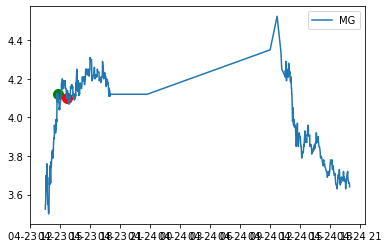

In [77]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))